In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
import optuna
import cudf
import cuml
import xgboost
from xgboost import XGBRegressor
from cuml.linear_model import LinearRegression, Lasso, Ridge
from cuml.ensemble import RandomForestClassifier, RandomForestRegressor
from cuml import SVR

import catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, classification_report
import joblib
import time

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

In [2]:
!pip install colorama -q

In [3]:
from colorama import Fore, Style

In [4]:
!pip install optuna -q

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Load Dataset</h2>
</div>

In [5]:
train_targets_scored = pd.read_csv("./dataset/train_targets_scored.csv")
train_targets_scored.columns

Index(['sig_id', '5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor',
       'acat_inhibitor', 'acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor',
       'adenosine_receptor_agonist', 'adenosine_receptor_antagonist',
       'adenylyl_cyclase_activator',
       ...
       'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist',
       'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor',
       'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b',
       'vitamin_d_receptor_agonist', 'wnt_inhibitor'],
      dtype='object', length=207)

In [6]:
train_df = pd.read_csv("train_df.csv")
train_df

,cp_time,sig_id,cp_type,cp_dose,PC_g1,PC_g2,PC_g3,PC_g4,PC_g5,PC_g6,...,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,label,drug_id
0,24,id_000644bb2,trt_cp,D1,0.442910,0.067050,-0.671705,-1.241222,-0.693577,-1.042251,...,0,0,0,0,0,0,0,0,0,b68db1d53
1,72,id_000779bfc,trt_cp,D1,0.353196,-0.451684,1.594889,0.102996,0.406712,1.008423,...,0,0,0,0,0,0,0,0,1,df89a8e5a
2,48,id_000a6266a,trt_cp,D1,0.090265,-0.315512,-0.132467,1.261654,0.290351,-0.362575,...,0,0,0,0,0,0,0,0,2,18bb41b2c
3,48,id_0015fd391,trt_cp,D1,-0.501163,0.663291,-0.296699,2.030823,0.238489,-2.191095,...,0,0,0,0,0,0,0,0,1,8c7f86626
4,72,id_001626bd3,trt_cp,D2,0.388561,-0.015293,1.397876,1.325872,0.127996,-0.914443,...,0,0,0,0,0,0,0,0,3,7cbed3131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22823,24,id_fffb1ceed,trt_cp,D2,0.325422,-0.402119,-0.106127,0.697887,0.156652,-0.190810,...,0,0,0,0,0,0,0,0,23,df1d0a5a1
22824,24,id_fffb70c0c,trt_cp,D2,0.267785,0.074992,-0.275417,-0.039679,-0.965713,-0.044896,...,0,0,0,0,0,0,0,0,143,ecf3b6b74
22825,48,id_fffc1c3f4,ctl_vehicle,D2,0.352686,0.188554,-0.140731,-0.095244,0.169479,-0.316924,...,0,0,0,0,0,0,0,0,1,cacb2b860
22826,24,id_fffcb9e7c,trt_cp,D1,-0.407472,2.835715,-0.273336,-2.261108,1.620685,-0.040259,...,0,0,0,0,0,0,0,0,4,8b87a7a83


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Define features</h2>
</div>

In [7]:
continuous_columns = [col for col in train_df.select_dtypes(include='number').columns if train_df[col].nunique() > 10]
continuous_columns = continuous_columns[:-1]
print("Continuous Features:", continuous_columns)

Continuous Features: ['PC_g1', 'PC_g2', 'PC_g3', 'PC_g4', 'PC_g5', 'PC_g6', 'PC_g7', 'PC_g8', 'PC_g9', 'PC_g10', 'PC_g11', 'PC_g12', 'PC_g13', 'PC_g14', 'PC_g15', 'PC_g16', 'PC_g17', 'PC_g18', 'PC_g19', 'PC_g20', 'PC_g21', 'PC_g22', 'PC_g23', 'PC_g24', 'PC_g25', 'PC_g26', 'PC_g27', 'PC_g28', 'PC_g29', 'PC_g30', 'PC_g31', 'PC_g32', 'PC_g33', 'PC_g34', 'PC_g35', 'PC_g36', 'PC_g37', 'PC_g38', 'PC_g39', 'PC_g40', 'PC_g41', 'PC_g42', 'PC_g43', 'PC_g44', 'PC_g45', 'PC_g46', 'PC_g47', 'PC_g48', 'PC_g49', 'PC_g50', 'PC_g51', 'PC_g52', 'PC_g53', 'PC_g54', 'PC_g55', 'PC_g56', 'PC_g57', 'PC_g58', 'PC_g59', 'PC_g60', 'PC_g61', 'PC_g62', 'PC_g63', 'PC_g64', 'PC_g65', 'PC_g66', 'PC_g67', 'PC_g68', 'PC_g69', 'PC_g70', 'PC_g71', 'PC_g72', 'PC_g73', 'PC_g74', 'PC_g75', 'PC_g76', 'PC_g77', 'PC_g78', 'PC_g79', 'PC_g80', 'PC_g81', 'PC_g82', 'PC_g83', 'PC_g84', 'PC_g85', 'PC_g86', 'PC_g87', 'PC_g88', 'PC_g89', 'PC_g90', 'PC_g91', 'PC_g92', 'PC_g93', 'PC_g94', 'PC_g95', 'PC_g96', 'PC_g97', 'PC_g98', 'PC_g99

In [8]:
categorical_features = set(train_df.columns)-set(continuous_columns)
categorical_features = list(categorical_features)
categorical_features = set(categorical_features)- set(train_targets_scored.columns[1:])
print(categorical_features)

{'cp_time', 'cp_type', 'label', 'drug_id', 'cp_dose', 'sig_id'}


In [9]:
categorical_features = list(categorical_features)
categorical_features

['cp_time', 'cp_type', 'label', 'drug_id', 'cp_dose', 'sig_id']

In [10]:
train_df.cp_time = train_df.cp_time.map({24:"24", 48:"48", 72:"72"})

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Visualization Target Class</h2>
</div>

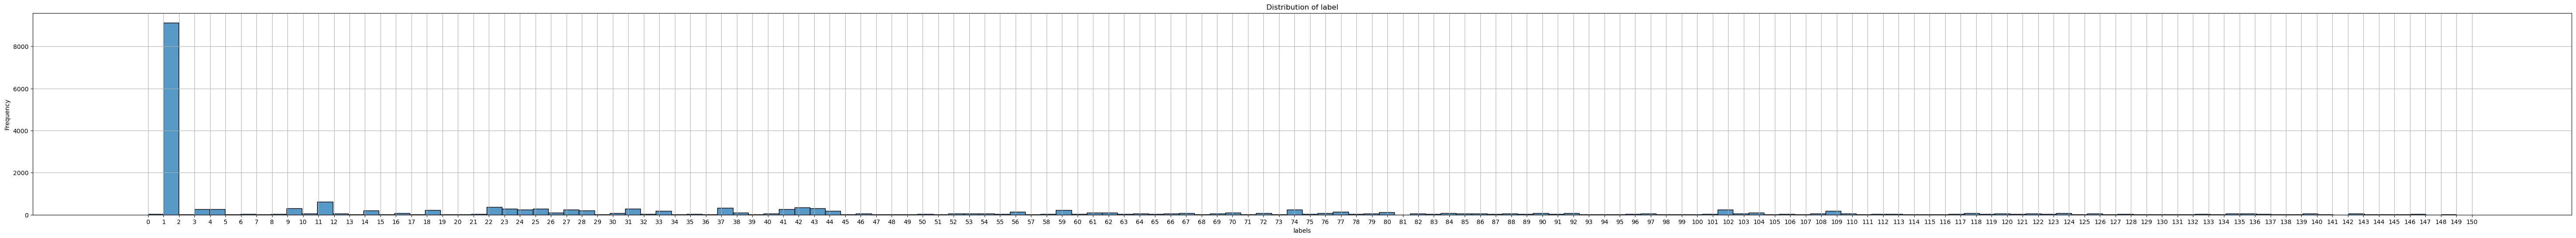

In [11]:
plt.figure(figsize=(75, 6))
sns.histplot(data=train_df[train_df.label < 150], x='label', bins=150)
plt.title('Distribution of label')
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 151, 1))
plt.show()

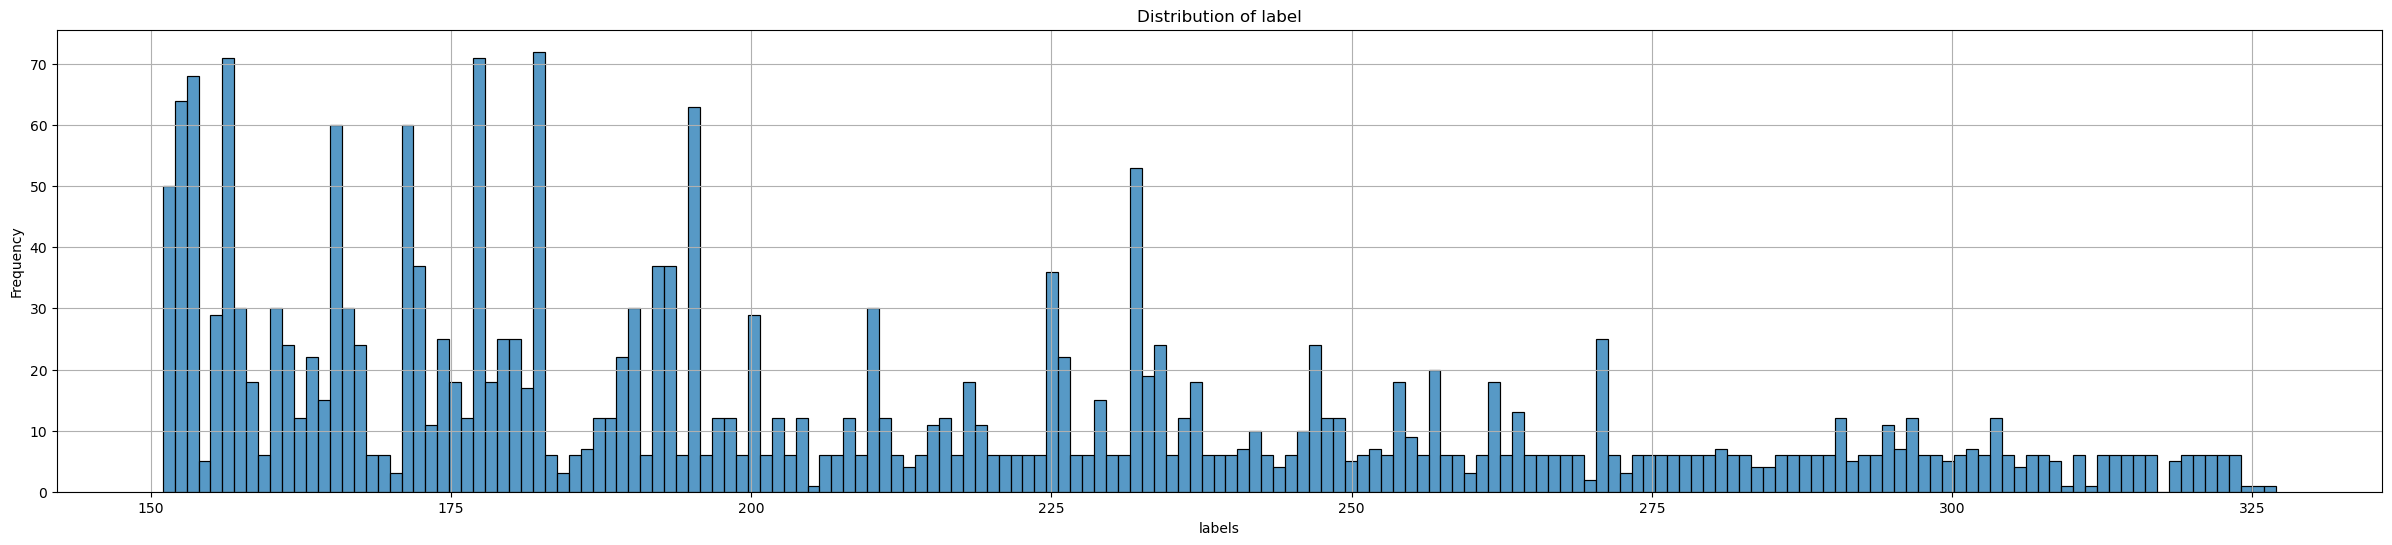

In [12]:
plt.figure(figsize=(30, 6))
sns.histplot(data=train_df[train_df.label > 150], x='label', bins=(train_df.label.nunique()-150))
plt.title('Distribution of label')
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.grid(True)
# plt.xticks(range(0, (train_df.label.nunique()-150), 1))
plt.show()

In [11]:
from sklearn.model_selection import StratifiedKFold
X = train_df.drop(columns=['label'])
y = train_df['label']
groups = train_df.label

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    break

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Feature Selection</h2>
</div>

In [12]:
X_train.columns

Index(['cp_time', 'sig_id', 'cp_type', 'cp_dose', 'PC_g1', 'PC_g2', 'PC_g3',
       'PC_g4', 'PC_g5', 'PC_g6',
       ...
       'trpv_agonist', 'trpv_antagonist', 'tubulin_inhibitor',
       'tyrosine_kinase_inhibitor', 'ubiquitin_specific_protease_inhibitor',
       'vegfr_inhibitor', 'vitamin_b', 'vitamin_d_receptor_agonist',
       'wnt_inhibitor', 'drug_id'],
      dtype='object', length=395)

In [13]:
X_train.drop(columns=train_targets_scored.columns[1:], inplace = True)
X_test.drop(columns=train_targets_scored.columns[1:], inplace = True)

In [14]:
!pip install catboost -q

In [15]:
categorical_features.remove('label')
categorical_features.remove('sig_id')
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [16]:
X_train.drop(columns=['sig_id'], inplace=True)
X_test.drop(columns=['sig_id'], inplace=True)

In [17]:
# !pip install numba -q
"""from numba import cuda 
device = cuda.get_current_device()
device.reset()"""

'from numba import cuda \ndevice = cuda.get_current_device()\ndevice.reset()'

In [18]:
import gc
gc.collect()

35

In [19]:
categorical_features

['cp_time', 'cp_type', 'drug_id', 'cp_dose']

In [20]:
%%time
"""catboost_1 = CatBoostRegressor(verbose=0, eval_metric="RMSE",  cat_features= list(categorical_features),                                      
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_1.fit(X_train, y_train)
"""
catboost_1 = joblib.load('catboost_1.pkl')
y_pred = catboost_1.predict(X_test)
y_pred_train = catboost_1.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
print(f"Test RMSE: {r2_score(y_test, y_pred)}")

importances = catboost_1.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)
# joblib.dump(catboost_1, "catboost_1.pkl")
# del catboost_1

Train RMSE: 0.6622953035081567
Test RMSE: 0.5037592698124522
     Feature  Gini Importance
187  drug_id        55.146192
181    PC_c4         1.021759
0    cp_time         0.808674
37    PC_g35         0.574121
28    PC_g26         0.509348
..       ...              ...
138  PC_g136         0.069400
1    cp_type         0.069193
67    PC_g65         0.067037
125  PC_g123         0.055974
2    cp_dose         0.006510

[188 rows x 2 columns]
CPU times: user 101 ms, sys: 82.6 ms, total: 183 ms
Wall time: 156 ms


In [21]:
feature_imp_df[feature_imp_df['Gini Importance'] > np.mean(feature_imp_df['Gini Importance'])]

,Feature,Gini Importance
187,drug_id,55.146192
181,PC_c4,1.021759
0,cp_time,0.808674
37,PC_g35,0.574121


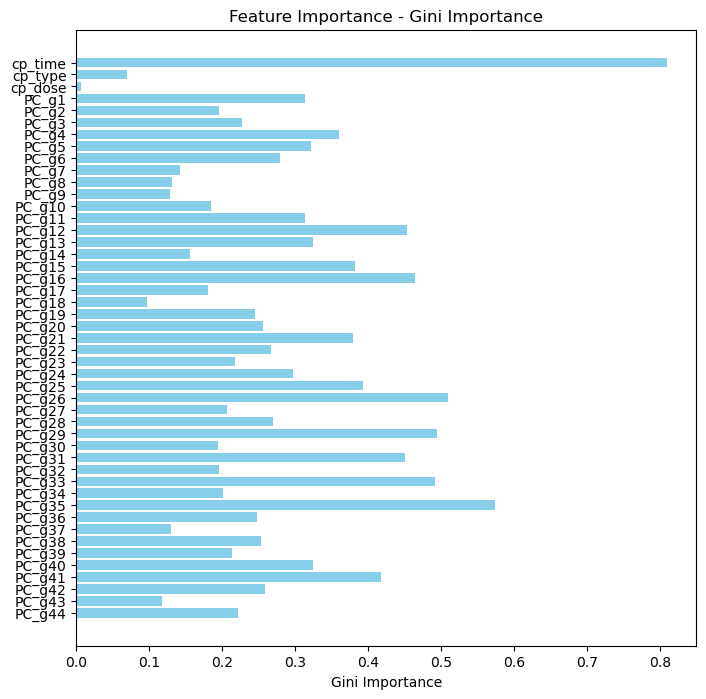

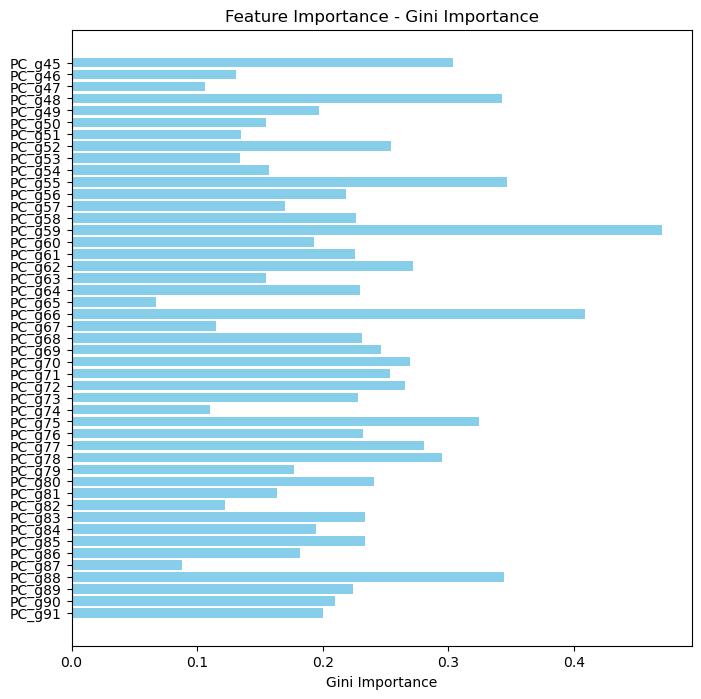

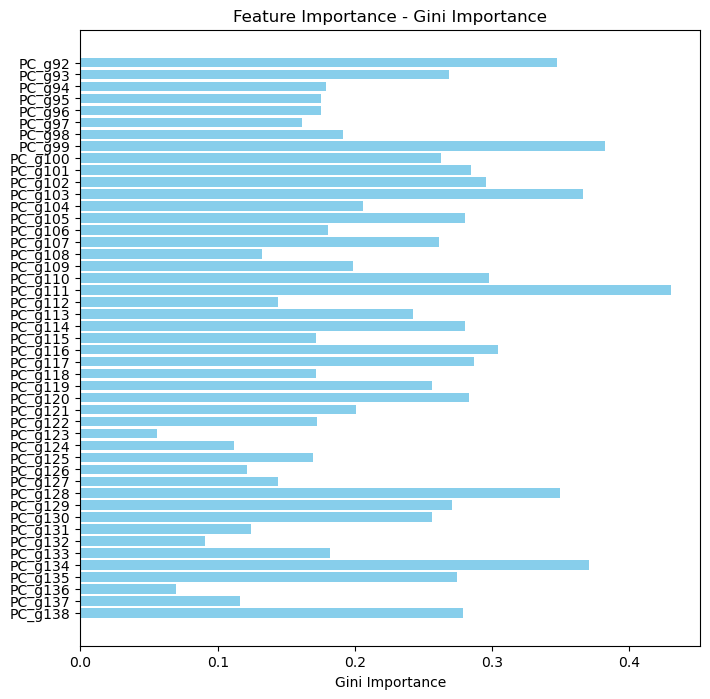

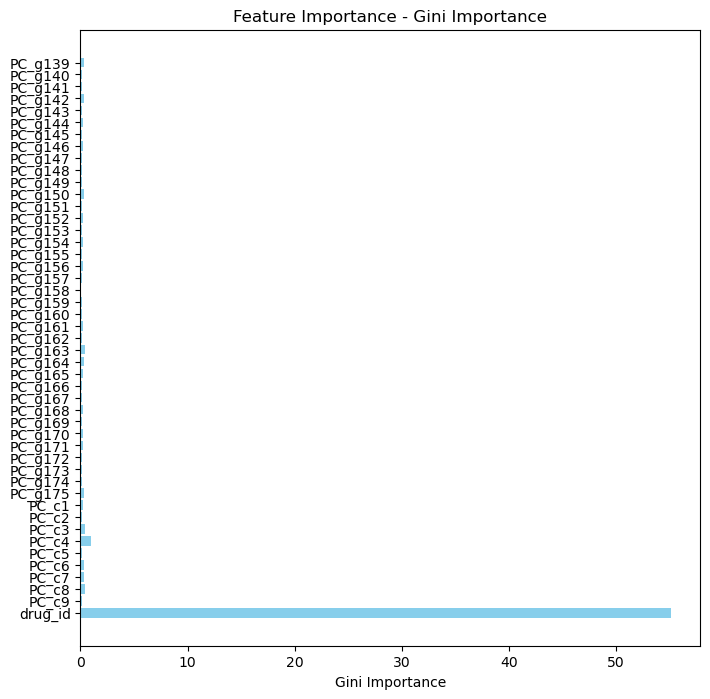

In [24]:
counter = 0
for i in range(1,5):
    plt.figure(figsize=(8, 8))
    plt.barh(X_train.columns[counter:i*47], importances[counter:i*47], color='skyblue')
    plt.xlabel('Gini Importance')
    plt.title('Feature Importance - Gini Importance')
    plt.gca().invert_yaxis()
    plt.show()
    counter= i*47

In [28]:
feature_imp_df.Feature

187    drug_id
181      PC_c4
0      cp_time
37      PC_g35
28      PC_g26
        ...   
138    PC_g136
1      cp_type
67      PC_g65
125    PC_g123
2      cp_dose
Name: Feature, Length: 188, dtype: object

Train RMSE: 0.5027898711776624
Test RMSE: 0.49407684100083715
Train RMSE: 0.5204356921013349
Test RMSE: 0.4997836801806086
Train RMSE: 0.513272913780051
Test RMSE: 0.4954740426737929
Train RMSE: 0.5180797113457812
Test RMSE: 0.49614926388174485
Train RMSE: 0.527305617502593
Test RMSE: 0.49945939146145046
Train RMSE: 0.5330481096823708
Test RMSE: 0.5019951219417067
Train RMSE: 0.5390854202502793
Test RMSE: 0.5015660504807831
Train RMSE: 0.5444281078748816
Test RMSE: 0.50258327660969
Train RMSE: 0.5486264838529209
Test RMSE: 0.5036876402459896
Train RMSE: 0.5565638300722195
Test RMSE: 0.5074348867330574
Train RMSE: 0.557627564686778
Test RMSE: 0.5049481499953723
Train RMSE: 0.5646051488019695
Test RMSE: 0.5069937194692765
Train RMSE: 0.5697395444703834
Test RMSE: 0.5045702563711087
Train RMSE: 0.5737947790771392
Test RMSE: 0.5053490727962425
Train RMSE: 0.5759526795958327
Test RMSE: 0.5026492242208562
Train RMSE: 0.5803077663482414
Test RMSE: 0.5042191447176936
Train RMSE: 0.577569966303

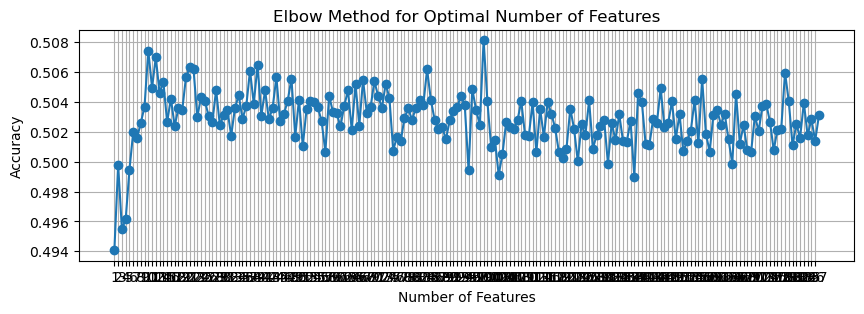

In [25]:
feature_importances = feature_imp_df.Feature
accuracies = []

for i in range(1, X_train.shape[1] + 1):
    selected_features = feature_importances[:i].index
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    intersection_categorical_features = list(set(list(feature_imp_df[:i].Feature)).intersection(list(categorical_features)))
    catboost_1 = CatBoostRegressor(verbose=0, eval_metric="RMSE",  cat_features= intersection_categorical_features,                                      
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
    catboost_1.fit(X_train_selected, y_train)
    y_pred = catboost_1.predict(X_test_selected)
    accuracies.append(r2_score(y_test, y_pred))
    y_pred_train = catboost_1.predict(X_train_selected)
    print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
    print(f"Test RMSE: {accuracies[-1]}")
    del catboost_1

plt.figure(figsize=(10, 3))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xticks(np.arange(1, len(feature_importances), 1))
plt.title('Elbow Method for Optimal Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

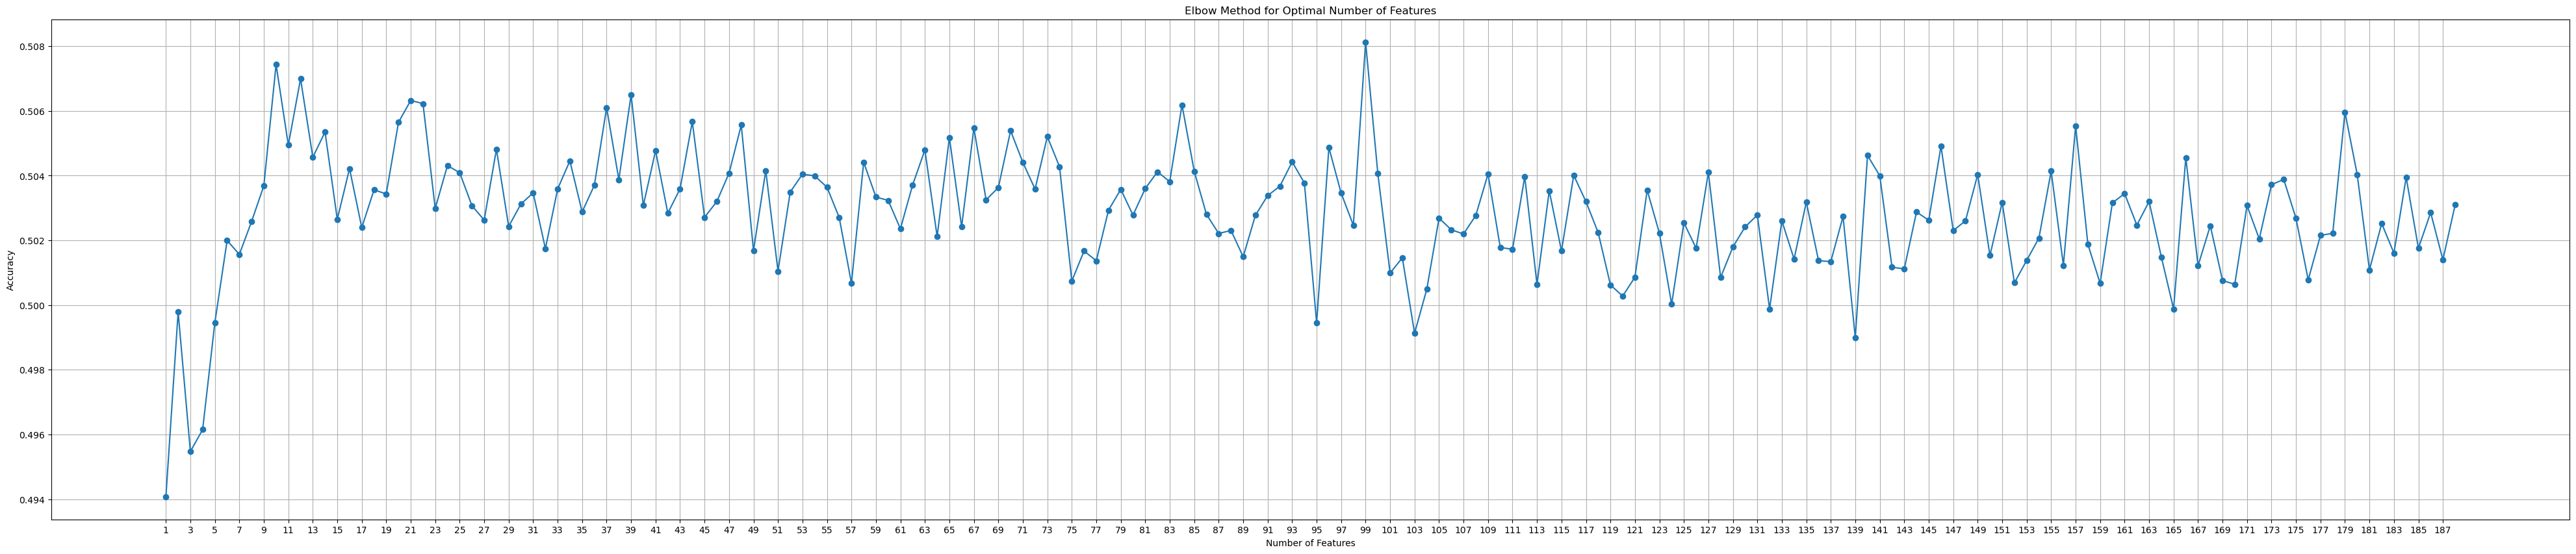

In [30]:
plt.figure(figsize=(50, 10))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xticks(np.arange(1, len(feature_importances), 2))
plt.title('Elbow Method for Optimal Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

In [22]:
feature_imp_df[:11]

,Feature,Gini Importance
187,drug_id,55.146192
181,PC_c4,1.021759
0,cp_time,0.808674
37,PC_g35,0.574121
28,PC_g26,0.509348
31,PC_g29,0.494245
35,PC_g33,0.491182
61,PC_g59,0.470327
18,PC_g16,0.464418
14,PC_g12,0.453590


In [24]:
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 110%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">One-Hot Encoding</h2>
</div>

In [23]:
continuous_columns = [col for col in train_df.select_dtypes(include='number').columns if train_df[col].nunique() > 10]
continuous_columns = continuous_columns[:-1]
print("Continuous Features:", continuous_columns)

Continuous Features: ['PC_g1', 'PC_g2', 'PC_g3', 'PC_g4', 'PC_g5', 'PC_g6', 'PC_g7', 'PC_g8', 'PC_g9', 'PC_g10', 'PC_g11', 'PC_g12', 'PC_g13', 'PC_g14', 'PC_g15', 'PC_g16', 'PC_g17', 'PC_g18', 'PC_g19', 'PC_g20', 'PC_g21', 'PC_g22', 'PC_g23', 'PC_g24', 'PC_g25', 'PC_g26', 'PC_g27', 'PC_g28', 'PC_g29', 'PC_g30', 'PC_g31', 'PC_g32', 'PC_g33', 'PC_g34', 'PC_g35', 'PC_g36', 'PC_g37', 'PC_g38', 'PC_g39', 'PC_g40', 'PC_g41', 'PC_g42', 'PC_g43', 'PC_g44', 'PC_g45', 'PC_g46', 'PC_g47', 'PC_g48', 'PC_g49', 'PC_g50', 'PC_g51', 'PC_g52', 'PC_g53', 'PC_g54', 'PC_g55', 'PC_g56', 'PC_g57', 'PC_g58', 'PC_g59', 'PC_g60', 'PC_g61', 'PC_g62', 'PC_g63', 'PC_g64', 'PC_g65', 'PC_g66', 'PC_g67', 'PC_g68', 'PC_g69', 'PC_g70', 'PC_g71', 'PC_g72', 'PC_g73', 'PC_g74', 'PC_g75', 'PC_g76', 'PC_g77', 'PC_g78', 'PC_g79', 'PC_g80', 'PC_g81', 'PC_g82', 'PC_g83', 'PC_g84', 'PC_g85', 'PC_g86', 'PC_g87', 'PC_g88', 'PC_g89', 'PC_g90', 'PC_g91', 'PC_g92', 'PC_g93', 'PC_g94', 'PC_g95', 'PC_g96', 'PC_g97', 'PC_g98', 'PC_g99

In [24]:
X = train_df.drop(columns=['label'])
y = train_df['label']
groups = train_df.label

In [25]:
categorical_features

['cp_time', 'cp_type', 'drug_id', 'cp_dose']

In [26]:
set(feature_imp_df[:11].Feature.values)

{'PC_c4',
 'PC_g12',
 'PC_g16',
 'PC_g26',
 'PC_g29',
 'PC_g31',
 'PC_g33',
 'PC_g35',
 'PC_g59',
 'cp_time',
 'drug_id'}

In [152]:
for col in categorical_features:
    X[col] = X[col].astype(str)

In [27]:
from sklearn.preprocessing import OneHotEncoder

selected_features = list(feature_imp_df[:11].Feature)
columns_to_encode = list(set(feature_imp_df[1:11].Feature.values).intersection(set(categorical_features)))
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(X[columns_to_encode])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(columns_to_encode))
X = pd.concat([X[selected_features[1:11]], encoded_df], axis=1)
X.drop(columns=['cp_time'], inplace=True)
X

,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,cp_time_24,cp_time_48,cp_time_72
0,-0.132293,-0.133383,0.357710,0.253488,0.941469,-1.136010,0.016309,0.110647,-0.259852,1.0,0.0,0.0
1,0.531818,-0.635519,-0.388408,-0.230593,0.680430,0.826543,1.255156,-0.739346,-0.648797,0.0,0.0,1.0
2,-0.685792,-1.155077,-0.920859,0.245479,0.002656,0.602549,0.015226,0.390653,-1.132681,0.0,1.0,0.0
3,2.373990,-0.542576,-0.702529,-1.319536,0.141374,-2.201130,-0.817164,-0.160564,-0.004769,0.0,1.0,0.0
4,-0.449325,0.244811,-0.252866,-0.622214,0.438755,0.737301,-0.526465,-0.653689,-0.950623,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
22823,0.516935,-1.396919,0.152807,0.290296,-0.096480,2.666534,-0.329622,0.618883,-0.301461,1.0,0.0,0.0
22824,-0.105286,0.778199,0.175567,0.348669,0.849665,1.350190,-0.232379,-0.130893,-1.332653,1.0,0.0,0.0
22825,0.438032,1.495995,0.254508,-0.528029,-0.031875,0.134160,0.320971,0.346726,-0.028330,0.0,1.0,0.0
22826,-0.221913,0.213595,0.656053,2.527591,1.123188,-0.434306,0.445438,-0.867326,-0.021720,1.0,0.0,0.0


# drug_id feature exploration

In [32]:
train_df['drug_id']

0        b68db1d53
1        df89a8e5a
2        18bb41b2c
3        8c7f86626
4        7cbed3131
           ...    
22823    df1d0a5a1
22824    ecf3b6b74
22825    cacb2b860
22826    8b87a7a83
22827    972f41291
Name: drug_id, Length: 22828, dtype: object

In [33]:
train_df['drug_id'].nunique()

3259

In [28]:
encoder = OneHotEncoder(sparse_output=False)
encoded_array_drug = encoder.fit_transform(train_df[['drug_id']])
encoded_drug_df = pd.DataFrame(encoded_array_drug, columns=encoder.get_feature_names_out(['drug_id']))
drug_df = pd.concat([encoded_drug_df, train_df[['label']]], axis=1)
drug_df

,drug_id_00199ff52,drug_id_00251fc41,drug_id_00321ea80,drug_id_0034c0847,drug_id_0060e686f,drug_id_00898e82c,drug_id_009a5da05,drug_id_00d2de1d8,drug_id_00dba5599,drug_id_014d175d7,...,drug_id_ff539cce7,drug_id_ff551f3a3,drug_id_ff55b75c9,drug_id_ff5a3ecb1,drug_id_ff9565933,drug_id_ffd66e220,drug_id_ffe357f8f,drug_id_ffed8e1c9,drug_id_fff7d208d,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23
22824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143
22825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


# Each drug importance to label

In [29]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_drug = drug_df.iloc[:, :-1]
y_drug = drug_df.iloc[:,-1]
for train_index, test_index in kf.split(X_drug, y_drug):
    X_train_drug_id, X_test_drug_id = X_drug.loc[train_index], X_drug.loc[test_index]
    y_train_drug_id, y_test_drug_id = y_drug.loc[train_index], y_drug.loc[test_index]
    break   

In [30]:
catboost_drug_id = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_drug_id.fit(X_train_drug_id, y_train_drug_id)
y_pred_drug_id = catboost_drug_id.predict(X_test_drug_id)
y_pred_train_drug_id = catboost_drug_id.predict(X_train_drug_id)

print(f"Train RMSE: {r2_score(y_train_drug_id, y_pred_train_drug_id)}")
print(f"Test RMSE: {r2_score(y_test_drug_id, y_pred_drug_id)}")

Train RMSE: 0.4984577789686496
Test RMSE: 0.466217578230958


In [84]:
gc.collect()

0

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Using only the drug_id feature gives very good results but it is not in the test dataset so this feature will be used to improve model train performance.</h2>
</div>

In [31]:
importances_drug_id = catboost_drug_id.feature_importances_
feature_imp_df_drug_id = pd.DataFrame({'Feature': X_train_drug_id.columns, 'Gini Importance': importances_drug_id}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df_drug_id)

                Feature  Gini Importance
2517  drug_id_cacb2b860        13.178881
1645  drug_id_87d714366         2.687035
2135  drug_id_ae0c59f9b         1.026962
1686  drug_id_8b87a7a83         0.940668
3236  drug_id_fe8625cad         0.900093
...                 ...              ...
1165  drug_id_62ad50147         0.000000
1166  drug_id_62be1e189         0.000000
1167  drug_id_62e323023         0.000000
1168  drug_id_62ff1ff60         0.000000
3258  drug_id_fff7d208d         0.000000

[3259 rows x 2 columns]


In [104]:
feature_imp_df_drug_id

,Feature,Gini Importance
2517,drug_id_cacb2b860,13.178881
1645,drug_id_87d714366,2.687035
2135,drug_id_ae0c59f9b,1.026962
1686,drug_id_8b87a7a83,0.940668
3236,drug_id_fe8625cad,0.900093
...,...,...
1165,drug_id_62ad50147,0.000000
1166,drug_id_62be1e189,0.000000
1167,drug_id_62e323023,0.000000
1168,drug_id_62ff1ff60,0.000000


In [32]:
feature_imp_df_drug_id = feature_imp_df_drug_id[feature_imp_df_drug_id["Gini Importance"]>0]
importances_drug_id = importances_drug_id[feature_imp_df_drug_id.index].copy()
feature_imp_df_drug_id

,Feature,Gini Importance
2517,drug_id_cacb2b860,13.178881
1645,drug_id_87d714366,2.687035
2135,drug_id_ae0c59f9b,1.026962
1686,drug_id_8b87a7a83,0.940668
3236,drug_id_fe8625cad,0.900093
...,...,...
2387,drug_id_c1292b6d8,0.000054
72,drug_id_07cca32e8,0.000054
196,drug_id_125db1da8,0.000052
548,drug_id_2b06f0b4b,0.000006


In [122]:
importances_drug_id

array([1.31788810e+01, 2.68703549e+00, 1.02696240e+00, 9.40667604e-01,
       9.00093253e-01, 8.69780866e-01, 8.60219003e-01, 8.19926902e-01,
       7.90236294e-01, 7.83390503e-01, 7.69849077e-01, 7.59476243e-01,
       7.53926832e-01, 7.52585070e-01, 7.46676672e-01, 7.41819481e-01,
       7.41414172e-01, 7.40862374e-01, 7.13684555e-01, 7.11383680e-01,
       7.01619475e-01, 7.01562328e-01, 6.89762017e-01, 6.74552859e-01,
       6.70565819e-01, 6.61144872e-01, 6.57569552e-01, 6.34264373e-01,
       6.27784770e-01, 6.22471516e-01, 6.16292795e-01, 6.13472491e-01,
       6.11257525e-01, 6.02531607e-01, 6.00460464e-01, 5.93512001e-01,
       5.82973242e-01, 5.82033455e-01, 5.78060888e-01, 5.76971457e-01,
       5.69488527e-01, 5.59241401e-01, 5.55745414e-01, 5.52459305e-01,
       5.52080683e-01, 5.31550973e-01, 5.28605839e-01, 5.22965599e-01,
       5.20408890e-01, 5.19749217e-01, 5.10247084e-01, 5.07028241e-01,
       5.03314776e-01, 5.01952188e-01, 4.98856724e-01, 4.97827921e-01,
      

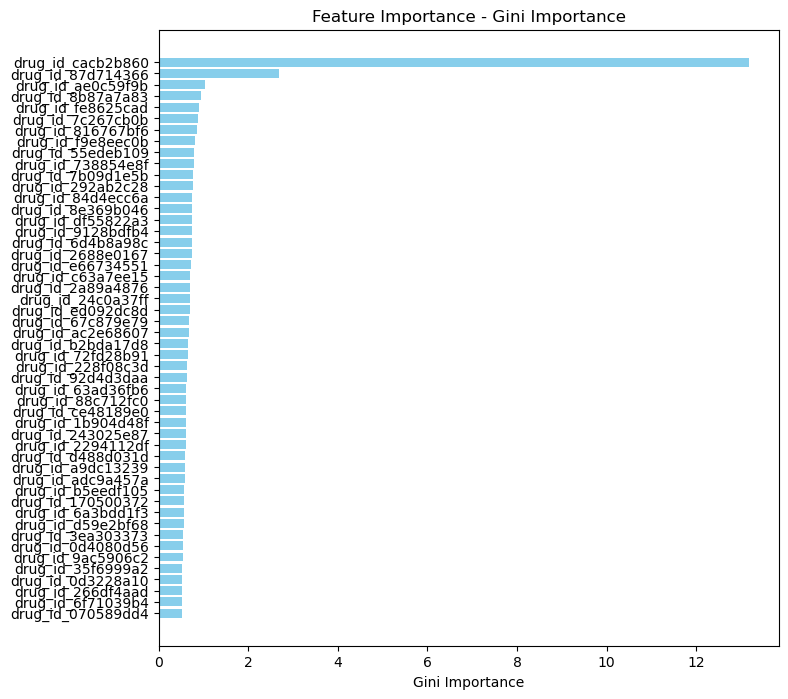

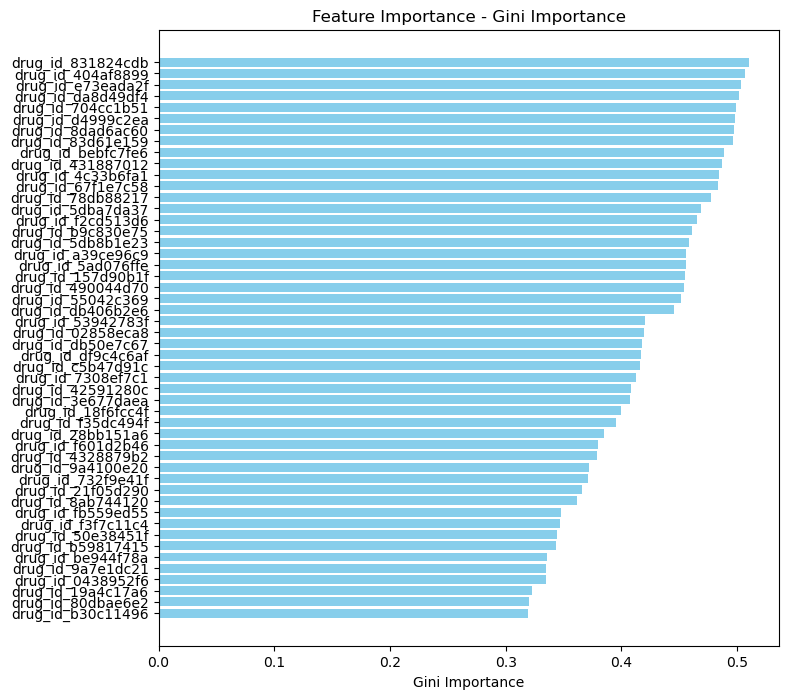

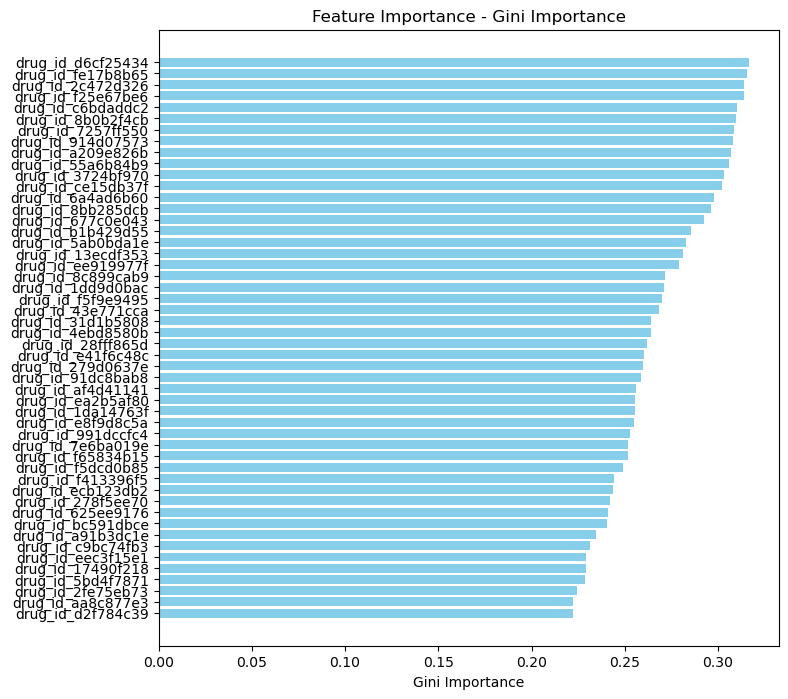

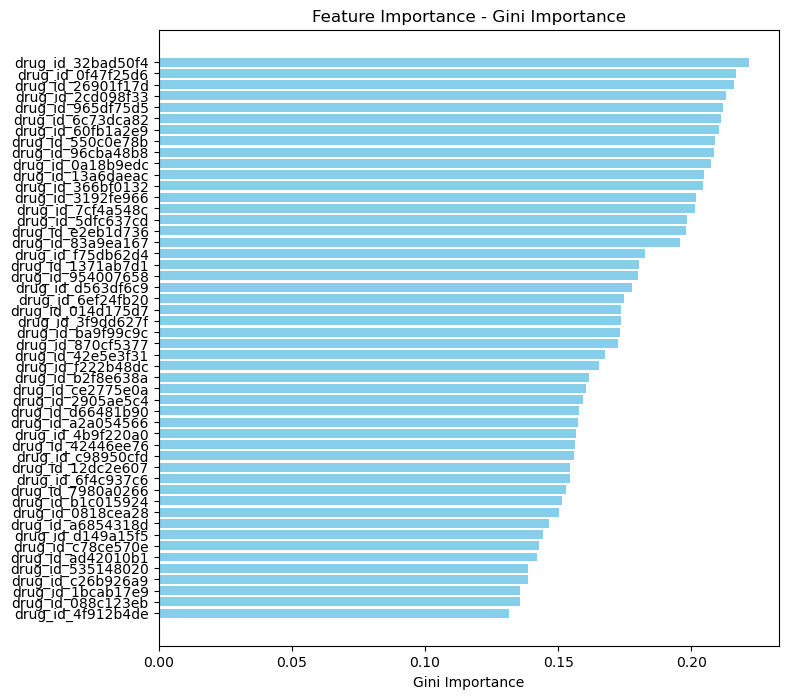

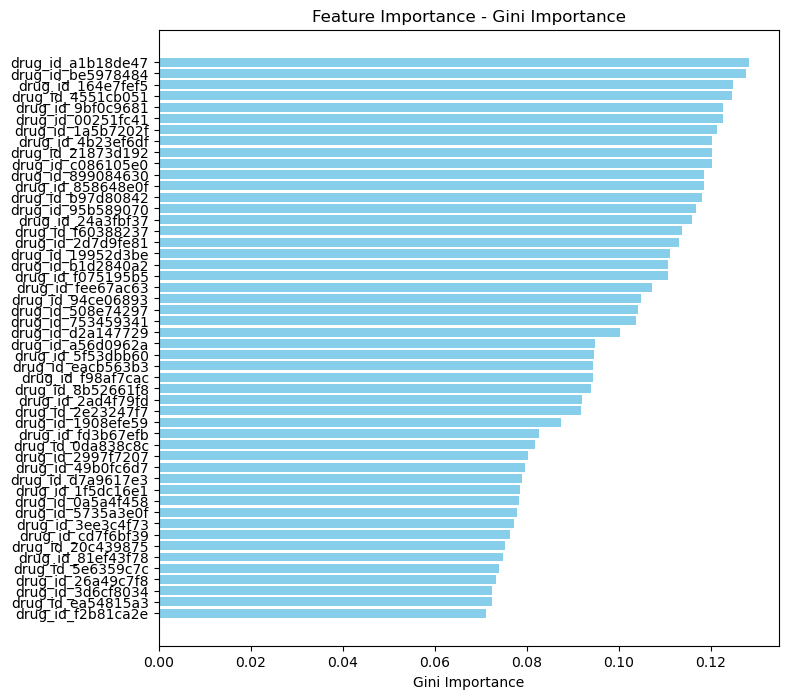

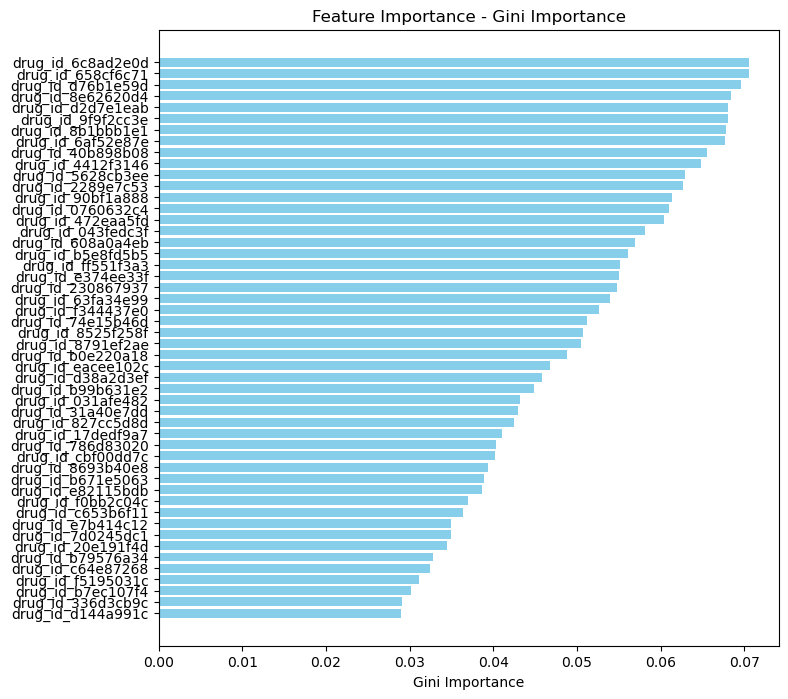

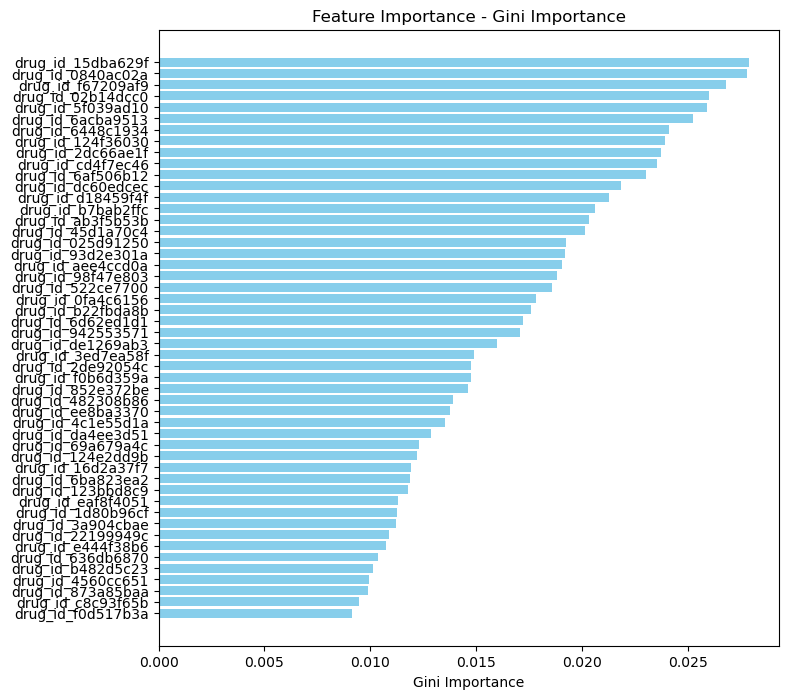

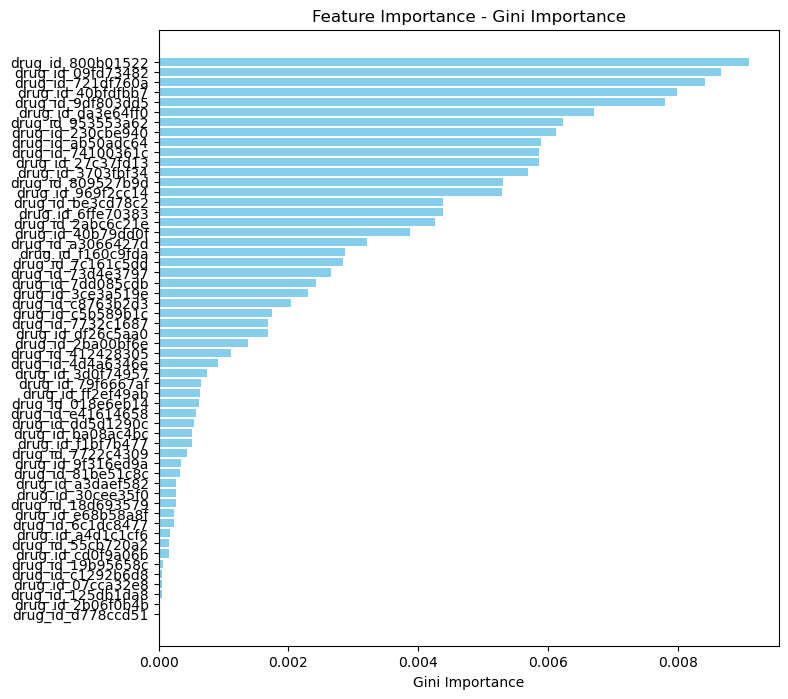

In [117]:
counter = 0
for i in range(1,8):
    plt.figure(figsize=(8, 8))
    plt.barh(feature_imp_df_drug_id["Feature"][counter:i*50], feature_imp_df_drug_id["Gini Importance"][counter:i*50], color='skyblue')
    plt.xlabel('Gini Importance')
    plt.title('Feature Importance - Gini Importance')
    plt.gca().invert_yaxis()
    plt.show()
    counter= i*50
plt.figure(figsize=(8, 8))
plt.barh(feature_imp_df_drug_id["Feature"][350:], feature_imp_df_drug_id["Gini Importance"][350:], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

Train RMSE: 0.04443363737010542
Test RMSE: 0.042367112643137084


Train RMSE: 0.055279964212462396
Test RMSE: 0.05313645649955856


Train RMSE: 0.059929272442305725
Test RMSE: 0.05936117310330258


Train RMSE: 0.06482373684478304
Test RMSE: 0.06430309221979524


Train RMSE: 0.06876086380946445
Test RMSE: 0.0674714627105727


Train RMSE: 0.07322984992375148
Test RMSE: 0.06747905292437728


Train RMSE: 0.07763077355889358
Test RMSE: 0.07042476457757463


Train RMSE: 0.08194953679572548
Test RMSE: 0.07389141344812278


Train RMSE: 0.08623888539131475
Test RMSE: 0.07733391110864973


Train RMSE: 0.09049891084119743
Test RMSE: 0.08075234282215771


Train RMSE: 0.09457208541448325
Test RMSE: 0.0840203692878384


Train RMSE: 0.0987765859750167
Test RMSE: 0.08836082156799119


Train RMSE: 0.10287065073551471
Test RMSE: 0.0916447479864223


Train RMSE: 0.10699870066665773
Test RMSE: 0.09495538643890589


Train RMSE: 0.11094278219349896
Test RMSE: 0.09811799184054792


Train RMSE: 0.11495109679772098
Test RMSE: 0.10133159085838561


Train RMSE: 0.11899297404357623
Test RMSE: 0.10457157647213755


Train RMSE: 0.12240552414270067
Test RMSE: 0.10761028438869813


Train RMSE: 0.1261084020132074
Test RMSE: 0.1100825036893579


Train RMSE: 0.1295665756911869
Test RMSE: 0.11007849175397444


Train RMSE: 0.1339360606824581
Test RMSE: 0.1135764022484167


Train RMSE: 0.13777636863584397
Test RMSE: 0.11664977246198227


Train RMSE: 0.14155856524227917
Test RMSE: 0.11967621035387399


Train RMSE: 0.1445241690843344
Test RMSE: 0.12204352783116812


Train RMSE: 0.14813428681924823
Test RMSE: 0.12493088025166788


Train RMSE: 0.1516582962558014
Test RMSE: 0.12774863022901617


Train RMSE: 0.1552140808924911
Test RMSE: 0.13059154302353493


Train RMSE: 0.158889590742036
Test RMSE: 0.1335297700616621


Train RMSE: 0.1624491819428211
Test RMSE: 0.13637466807892284


Train RMSE: 0.1659528603650755
Test RMSE: 0.13636323288587038


Train RMSE: 0.16943106893921778
Test RMSE: 0.1391407785147698


Train RMSE: 0.17263080390639607
Test RMSE: 0.13912408401074006


Train RMSE: 0.17594064003493415
Test RMSE: 0.14176376230950483


Train RMSE: 0.17931053920745788
Test RMSE: 0.14445114061087094


Train RMSE: 0.18265322560060815
Test RMSE: 0.147115074721623


Train RMSE: 0.1854882034861427
Test RMSE: 0.15277831158535427


Train RMSE: 0.18874967555885291
Test RMSE: 0.15537999112795386


Train RMSE: 0.1921567746647166
Test RMSE: 0.15809957505991878


Train RMSE: 0.19562063423585363
Test RMSE: 0.1608625053253363


Train RMSE: 0.19904731333383086
Test RMSE: 0.1677258478536916


Train RMSE: 0.20222292958675314
Test RMSE: 0.17025457232534646


Train RMSE: 0.20538415642994978
Test RMSE: 0.17277826245310612


Train RMSE: 0.2084366883591563
Test RMSE: 0.17521034627982313


Train RMSE: 0.21185118391977786
Test RMSE: 0.17862278346050486


Train RMSE: 0.21484109984055733
Test RMSE: 0.18100201844912678


Train RMSE: 0.21799021764506898
Test RMSE: 0.18414543056961374


Train RMSE: 0.22107314115593013
Test RMSE: 0.18660198201334055


Train RMSE: 0.2240255333394322
Test RMSE: 0.18895489154698364


Train RMSE: 0.22688746355676692
Test RMSE: 0.1912301476080378


Train RMSE: 0.22965884594146857
Test RMSE: 0.19121509663376457


Train RMSE: 0.23280489961701423
Test RMSE: 0.19751568541905296


Train RMSE: 0.2356247778948095
Test RMSE: 0.19975815270592567


Train RMSE: 0.23849984423813553
Test RMSE: 0.20204834853668718


Train RMSE: 0.24153441889191962
Test RMSE: 0.20814120059806251


Train RMSE: 0.24432231795592252
Test RMSE: 0.20810347951175934


Train RMSE: 0.24719386635802665
Test RMSE: 0.21038649968466905


Train RMSE: 0.2502723359517419
Test RMSE: 0.21033471224967215


Train RMSE: 0.2532947134585639
Test RMSE: 0.21273716550752175


Train RMSE: 0.25608866564307853
Test RMSE: 0.21495766496180813


Train RMSE: 0.25883295604514966
Test RMSE: 0.2171368861228945


Train RMSE: 0.2616139310471548
Test RMSE: 0.2193537671995308


Train RMSE: 0.26455848336130905
Test RMSE: 0.22228881745511597


Train RMSE: 0.2672466196066632
Test RMSE: 0.22219266937690918


Train RMSE: 0.26980176385339527
Test RMSE: 0.22422633398219782


Train RMSE: 0.27233628965825696
Test RMSE: 0.22623174229130327


Train RMSE: 0.2749829455661019
Test RMSE: 0.22831041264078045


Train RMSE: 0.2775876370069692
Test RMSE: 0.23037451005911314


Train RMSE: 0.280274016461866
Test RMSE: 0.23252168014153796


Train RMSE: 0.28329324222433827
Test RMSE: 0.2385933959883193


Train RMSE: 0.2861190498167019
Test RMSE: 0.24434310449250063


Train RMSE: 0.2886666978505902
Test RMSE: 0.2463743044674861


Train RMSE: 0.291340817421481
Test RMSE: 0.24848811040012442


Train RMSE: 0.29365793955123076
Test RMSE: 0.24837175967984992


Train RMSE: 0.2961639322065559
Test RMSE: 0.25037110444876154


Train RMSE: 0.298495762329411
Test RMSE: 0.25220155484624485


Train RMSE: 0.3012619576140376
Test RMSE: 0.254968747588581


Train RMSE: 0.30359496634938643
Test RMSE: 0.2564839902415096


Train RMSE: 0.30612813121029236
Test RMSE: 0.261697049012551


Train RMSE: 0.3085117999743038
Test RMSE: 0.2635795810080769


Train RMSE: 0.3110363601327828
Test RMSE: 0.26560471810574504


Train RMSE: 0.3133315167501778
Test RMSE: 0.26708284149456785


Train RMSE: 0.3157221912955841
Test RMSE: 0.2689941473734657


Train RMSE: 0.317948733964487
Test RMSE: 0.27077330704023717


Train RMSE: 0.32038775757879656
Test RMSE: 0.2757281724089867


Train RMSE: 0.322765256699757
Test RMSE: 0.2776163440507158


Train RMSE: 0.32539165791096714
Test RMSE: 0.2829423082461031


Train RMSE: 0.3276889261362319
Test RMSE: 0.2876070676076904


Train RMSE: 0.32982016563534433
Test RMSE: 0.2893321320862946


Train RMSE: 0.33208045070835135
Test RMSE: 0.29398750322297185


Train RMSE: 0.3340273249951159
Test RMSE: 0.2955174094023729


Train RMSE: 0.3360976245359789
Test RMSE: 0.2971732759327127


Train RMSE: 0.3382409697403941
Test RMSE: 0.3016145256066777


Train RMSE: 0.34005524327031067
Test RMSE: 0.30303831365270417


Train RMSE: 0.34199604582250076
Test RMSE: 0.3045680728808374


Train RMSE: 0.34380942811411463
Test RMSE: 0.30599893729382444


Train RMSE: 0.34577305290978433
Test RMSE: 0.3075231350696801


Train RMSE: 0.34781351260915117
Test RMSE: 0.30915955288809416


Train RMSE: 0.34965676266290724
Test RMSE: 0.3106093626127384


Train RMSE: 0.3515823693610871
Test RMSE: 0.312151325721609


Train RMSE: 0.3533519670905171
Test RMSE: 0.3135369955227213


Train RMSE: 0.35514315447292144
Test RMSE: 0.31944615702692025


Train RMSE: 0.3569404749275479
Test RMSE: 0.3208716761116056


Train RMSE: 0.35855376356411295
Test RMSE: 0.3206640308161107


Train RMSE: 0.3604325168138457
Test RMSE: 0.3221759917891762


Train RMSE: 0.3623194913558919
Test RMSE: 0.32364943818244274


Train RMSE: 0.3641531380545987
Test RMSE: 0.32511016285683547


Train RMSE: 0.36599025547415176
Test RMSE: 0.32652926407791105


Train RMSE: 0.3676413681840295
Test RMSE: 0.32772421209623126


Train RMSE: 0.3700197083479232
Test RMSE: 0.33257918588267343


Train RMSE: 0.37174298766995084
Test RMSE: 0.33392761017779593


Train RMSE: 0.3735605724607802
Test RMSE: 0.33574884980174435


Train RMSE: 0.3751492508577864
Test RMSE: 0.33696022328644404


Train RMSE: 0.3769117015897505
Test RMSE: 0.33827831713455503


Train RMSE: 0.3785977701415698
Test RMSE: 0.33962203333209207


Train RMSE: 0.380191246304563
Test RMSE: 0.3431966944003808


Train RMSE: 0.3818731159333899
Test RMSE: 0.34482124379404655


Train RMSE: 0.38347259499184627
Test RMSE: 0.3483240548996386


Train RMSE: 0.3851556576399222
Test RMSE: 0.34961819744766465


Train RMSE: 0.38672985978272
Test RMSE: 0.3493767323197813


Train RMSE: 0.38846251732242587
Test RMSE: 0.35081788001228953


Train RMSE: 0.3899075449400484
Test RMSE: 0.3539997940656773


Train RMSE: 0.3915218812017197
Test RMSE: 0.3540234141282165


Train RMSE: 0.39310266865071586
Test RMSE: 0.3573211583225506


Train RMSE: 0.3945614482107608
Test RMSE: 0.3606844653061666


Train RMSE: 0.3961671629686827
Test RMSE: 0.36194650176898413


Train RMSE: 0.39798773229431017
Test RMSE: 0.3657726995500584


Train RMSE: 0.3994510811679177
Test RMSE: 0.36687146528254166


Train RMSE: 0.40097005520621354
Test RMSE: 0.36806885361116126


Train RMSE: 0.4025309303030954
Test RMSE: 0.3703221601702733


Train RMSE: 0.4038216385097939
Test RMSE: 0.37119381516121697


Train RMSE: 0.4052322847494907
Test RMSE: 0.3723097628880384


Train RMSE: 0.4065959564409315
Test RMSE: 0.373391214853222


Train RMSE: 0.4079276681620534
Test RMSE: 0.37647825703404825


Train RMSE: 0.4093216468319608
Test RMSE: 0.37630357420860594


Train RMSE: 0.41065969153011517
Test RMSE: 0.37734402704257797


Train RMSE: 0.41222243147240467
Test RMSE: 0.37853482961722795


Train RMSE: 0.4137912690725575
Test RMSE: 0.38068755162816503


Train RMSE: 0.4151578731005585
Test RMSE: 0.3817573153787962


Train RMSE: 0.4167190670254658
Test RMSE: 0.38510563406285325


Train RMSE: 0.41787289990043697
Test RMSE: 0.38473732709635655


Train RMSE: 0.4193617809648814
Test RMSE: 0.3879115162702095


Train RMSE: 0.4203789642795229
Test RMSE: 0.3886536573270305


Train RMSE: 0.42149519085289056
Test RMSE: 0.38951422561604765


Train RMSE: 0.42268853691700414
Test RMSE: 0.3902029931872908


Train RMSE: 0.42400317796903797
Test RMSE: 0.3911921043062667


Train RMSE: 0.42503440157830386
Test RMSE: 0.3938262001108982


Train RMSE: 0.42617198089141517
Test RMSE: 0.3934638942866545


Train RMSE: 0.42729034646961406
Test RMSE: 0.39427207014894994


Train RMSE: 0.42838458745632557
Test RMSE: 0.39513427327981043


Train RMSE: 0.42946725052792567
Test RMSE: 0.39592233761345386


Train RMSE: 0.4305260187124488
Test RMSE: 0.39564201267683996


Train RMSE: 0.4315186059314985
Test RMSE: 0.39639485568965904


Train RMSE: 0.43247844177304107
Test RMSE: 0.39609782989581166


Train RMSE: 0.4334442259176312
Test RMSE: 0.3969134052153265


Train RMSE: 0.43460421807121197
Test RMSE: 0.39954154944227105


Train RMSE: 0.43561702290876114
Test RMSE: 0.4020405128131538


Train RMSE: 0.4367167797053808
Test RMSE: 0.4045279067371178


Train RMSE: 0.43784620646351724
Test RMSE: 0.40438522290517165


Train RMSE: 0.43893699675416953
Test RMSE: 0.4052540684046545


Train RMSE: 0.4398158009148442
Test RMSE: 0.40752500919008117


Train RMSE: 0.4409585442340851
Test RMSE: 0.4072470341816967


Train RMSE: 0.44181166448623843
Test RMSE: 0.4068563844004798


Train RMSE: 0.44287926020164914
Test RMSE: 0.4077006876577829


Train RMSE: 0.4438237714493146
Test RMSE: 0.4083108140896654


Train RMSE: 0.44477875896844965
Test RMSE: 0.41070948011840025


Train RMSE: 0.44564513146720686
Test RMSE: 0.412844052914783


Train RMSE: 0.4466041501553605
Test RMSE: 0.41405314108092184


Train RMSE: 0.44762979492860844
Test RMSE: 0.4148051005009099


Train RMSE: 0.4486636156253079
Test RMSE: 0.41557014054715546


Train RMSE: 0.4494656118088407
Test RMSE: 0.41766362591322737


Train RMSE: 0.45020043518226216
Test RMSE: 0.4184313642928623


Train RMSE: 0.45098382549805627
Test RMSE: 0.42027490979107707


Train RMSE: 0.45181843474304584
Test RMSE: 0.42014790434339866


Train RMSE: 0.4528932342420129
Test RMSE: 0.4199601037710283


Train RMSE: 0.4537466374735024
Test RMSE: 0.42197688482648155


Train RMSE: 0.4544838685827842
Test RMSE: 0.4224662521149568


Train RMSE: 0.4552766458984481
Test RMSE: 0.4221998403891112


Train RMSE: 0.4559812270991157
Test RMSE: 0.42191851406490377


Train RMSE: 0.4568636902577534
Test RMSE: 0.42265666348373754


Train RMSE: 0.45771806802053405
Test RMSE: 0.4241426769936031


Train RMSE: 0.45847436878539505
Test RMSE: 0.42381596504644004


Train RMSE: 0.45912262245465807
Test RMSE: 0.4255411981142725


Train RMSE: 0.459870149464619
Test RMSE: 0.4268466016763174


Train RMSE: 0.4605875665457604
Test RMSE: 0.42735446787788023


Train RMSE: 0.4614511623573063
Test RMSE: 0.4275818531765584


Train RMSE: 0.4619636953001649
Test RMSE: 0.42903923880716843


Train RMSE: 0.46265396522051394
Test RMSE: 0.4297228729848792


Train RMSE: 0.46349963806646
Test RMSE: 0.42960747049138204


Train RMSE: 0.4640273562661297
Test RMSE: 0.4291834111492344


Train RMSE: 0.46465791948239676
Test RMSE: 0.42964198175161106


Train RMSE: 0.46537069068415526
Test RMSE: 0.4301952350460335


Train RMSE: 0.4661001172339113
Test RMSE: 0.432065296402924


Train RMSE: 0.4666825905491331
Test RMSE: 0.43243251724768583


Train RMSE: 0.4672780213828732
Test RMSE: 0.4319507708469549


Train RMSE: 0.4677965301466356
Test RMSE: 0.4323719928919453


Train RMSE: 0.4685538653243826
Test RMSE: 0.43395490576262996


Train RMSE: 0.4692467661690706
Test RMSE: 0.43484837352702377


Train RMSE: 0.4698850968392242
Test RMSE: 0.4352709016844306


Train RMSE: 0.47039539940925235
Test RMSE: 0.4356712415305808


Train RMSE: 0.471159525458536
Test RMSE: 0.4362207504493659


Train RMSE: 0.47174841505139675
Test RMSE: 0.43666658983257944


Train RMSE: 0.47228254086880805
Test RMSE: 0.43688136445815884


Train RMSE: 0.4726692349060191
Test RMSE: 0.4372068389510565


Train RMSE: 0.47328873825479245
Test RMSE: 0.43763870268751104


Train RMSE: 0.47389294271243976
Test RMSE: 0.43815826125055624


Train RMSE: 0.4744885406324453
Test RMSE: 0.4386787533699159


Train RMSE: 0.47501808196475237
Test RMSE: 0.43967542954232264


Train RMSE: 0.4753922158663423
Test RMSE: 0.4400754097931825


Train RMSE: 0.4758446095448685
Test RMSE: 0.44042358195079867


Train RMSE: 0.47646380015002365
Test RMSE: 0.441462146473814


Train RMSE: 0.4768743207797862
Test RMSE: 0.4433964134948841


Train RMSE: 0.4771770517335515
Test RMSE: 0.44305579773722337


Train RMSE: 0.47777483792490316
Test RMSE: 0.44263906225178307


Train RMSE: 0.4782616145795946
Test RMSE: 0.44301296409156565


Train RMSE: 0.47872411481169463
Test RMSE: 0.44310872157421055


Train RMSE: 0.479082801940531
Test RMSE: 0.442810918314654


Train RMSE: 0.47951743976515404
Test RMSE: 0.4431633734852032


Train RMSE: 0.4800801707745084
Test RMSE: 0.44289755925785923


Train RMSE: 0.4805051543863752
Test RMSE: 0.44426421178121955


Train RMSE: 0.4811603894129429
Test RMSE: 0.4446680959179955


Train RMSE: 0.4815071700896878
Test RMSE: 0.44589637217733435


Train RMSE: 0.4818505914350486
Test RMSE: 0.44673087943737466


Train RMSE: 0.48230894433448657
Test RMSE: 0.4469505238115571


Train RMSE: 0.48269240204597086
Test RMSE: 0.44673009253944296


Train RMSE: 0.4831908291816994
Test RMSE: 0.4470901355996797


Train RMSE: 0.48348328179624556
Test RMSE: 0.4467124719932902


Train RMSE: 0.48390113990173866
Test RMSE: 0.44659325418261364


Train RMSE: 0.4844215280093431
Test RMSE: 0.4463556250870544


Train RMSE: 0.48477250444373254
Test RMSE: 0.4462911484265013


Train RMSE: 0.48491366659652635
Test RMSE: 0.4472091346226974


Train RMSE: 0.48533553703322774
Test RMSE: 0.448227081532245


Train RMSE: 0.48562555085793724
Test RMSE: 0.4479013261931971


Train RMSE: 0.48596961972672703
Test RMSE: 0.44780351699053944


Train RMSE: 0.48627886609922033
Test RMSE: 0.44797108231925853


Train RMSE: 0.48646153465278885
Test RMSE: 0.44906967825196553


Train RMSE: 0.48680064521585686
Test RMSE: 0.44935038916019887


Train RMSE: 0.48707854141739415
Test RMSE: 0.44952689115982136


Train RMSE: 0.48727922087806297
Test RMSE: 0.4496427758046765


Train RMSE: 0.48766894001859307
Test RMSE: 0.4498754454825209


Train RMSE: 0.4876450535171726
Test RMSE: 0.449715431269475


Train RMSE: 0.4883351182458163
Test RMSE: 0.4507636768503558


Train RMSE: 0.4886110821351297
Test RMSE: 0.45096000275401404


Train RMSE: 0.4886349630004322
Test RMSE: 0.45064591383352937


Train RMSE: 0.4888660994240701
Test RMSE: 0.4514826221031861


Train RMSE: 0.4891152349328747
Test RMSE: 0.45214144710054593


Train RMSE: 0.48942555409547384
Test RMSE: 0.45231932725745116


Train RMSE: 0.48968306718714605
Test RMSE: 0.4523366884846778


Train RMSE: 0.489713070595318
Test RMSE: 0.45411699315275


Train RMSE: 0.48992980672500863
Test RMSE: 0.4546828642965137


Train RMSE: 0.49014266700583564
Test RMSE: 0.4551455964964123


Train RMSE: 0.49047435980441734
Test RMSE: 0.455996759166288


Train RMSE: 0.49062055983590314
Test RMSE: 0.45610344589741036


Train RMSE: 0.4907770549010849
Test RMSE: 0.45676806925723024


Train RMSE: 0.4910660560835922
Test RMSE: 0.4568423423347139


Train RMSE: 0.4913804760397549
Test RMSE: 0.4569470980186955


Train RMSE: 0.49169095269561125
Test RMSE: 0.45726896243043347


Train RMSE: 0.49197817706992786
Test RMSE: 0.4574651783158432


Train RMSE: 0.4922865088402998
Test RMSE: 0.4572686584933474


Train RMSE: 0.49227058352287845
Test RMSE: 0.4574336628293


Train RMSE: 0.49252295068132823
Test RMSE: 0.4576046645463391


Train RMSE: 0.4925575388770078
Test RMSE: 0.45760417013004384


Train RMSE: 0.4927074327666948
Test RMSE: 0.4574121441823005


Train RMSE: 0.4929441461547812
Test RMSE: 0.4572825815034427


Train RMSE: 0.4932022535543814
Test RMSE: 0.45738740811514045


Train RMSE: 0.4935599884428452
Test RMSE: 0.4579747644220752


Train RMSE: 0.49378402097897545
Test RMSE: 0.4583020573893025


Train RMSE: 0.4939049036191737
Test RMSE: 0.458263298003314


Train RMSE: 0.4941201636671908
Test RMSE: 0.4590624820471858


Train RMSE: 0.49423792824012824
Test RMSE: 0.4589752818919105


Train RMSE: 0.49443580731795866
Test RMSE: 0.45877689652131326


Train RMSE: 0.4945749029889438
Test RMSE: 0.4586338605453468


Train RMSE: 0.49473013355051676
Test RMSE: 0.45887651802415896


Train RMSE: 0.4948491821524522
Test RMSE: 0.45882400710563476


Train RMSE: 0.4950330064862438
Test RMSE: 0.4589663647537773


Train RMSE: 0.4951655087021998
Test RMSE: 0.4591502929709198


Train RMSE: 0.49532989054428445
Test RMSE: 0.4592570053673073


Train RMSE: 0.49548645962436
Test RMSE: 0.45968373403146434


Train RMSE: 0.49567469905596884
Test RMSE: 0.4598665085756941


Train RMSE: 0.49576447862684825
Test RMSE: 0.4601180513049792


Train RMSE: 0.49583456580632645
Test RMSE: 0.4610761071002403


Train RMSE: 0.49596913521089314
Test RMSE: 0.4611588242962288


Train RMSE: 0.4960323890117857
Test RMSE: 0.4616910454914218


Train RMSE: 0.49622249289108433
Test RMSE: 0.4618767527104185


Train RMSE: 0.4963607332891439
Test RMSE: 0.462247498359899


Train RMSE: 0.4964577826403216
Test RMSE: 0.46242961148640194


Train RMSE: 0.4965662332933759
Test RMSE: 0.462524732113592


Train RMSE: 0.49668423891353186
Test RMSE: 0.4629805688746431


Train RMSE: 0.49679173107548924
Test RMSE: 0.46307813520627283


Train RMSE: 0.4969187567175102
Test RMSE: 0.4632531303095515


Train RMSE: 0.4968863518382466
Test RMSE: 0.4629812871054597


Train RMSE: 0.49699964884042647
Test RMSE: 0.46280026538507335


Train RMSE: 0.4971454489179479
Test RMSE: 0.4630036031373088


Train RMSE: 0.497155307593242
Test RMSE: 0.4629108404712522


Train RMSE: 0.4971723055924343
Test RMSE: 0.4630678394031199


Train RMSE: 0.49725614452739486
Test RMSE: 0.46324349405253495


Train RMSE: 0.49736527411798903
Test RMSE: 0.4633431759362314


Train RMSE: 0.49743300738964524
Test RMSE: 0.4632840918410932


Train RMSE: 0.4977032782022597
Test RMSE: 0.4636644632197576


Train RMSE: 0.49777968235503023
Test RMSE: 0.46368654487374916


Train RMSE: 0.4979238605955718
Test RMSE: 0.46463965411856667


Train RMSE: 0.4979209186772683
Test RMSE: 0.4648725680850043


Train RMSE: 0.4980139153226726
Test RMSE: 0.4652030143744005


Train RMSE: 0.49797336616539534
Test RMSE: 0.46505448849311726


Train RMSE: 0.49810285418446365
Test RMSE: 0.4651812501105762


Train RMSE: 0.4980937747905658
Test RMSE: 0.4650897361438422


Train RMSE: 0.4980835532424166
Test RMSE: 0.46494810039783707


Train RMSE: 0.49803827460286065
Test RMSE: 0.46520602335079564


Train RMSE: 0.4981332640120376
Test RMSE: 0.4654623085195905


Train RMSE: 0.4982912254419707
Test RMSE: 0.4656546252869602


Train RMSE: 0.49835094812959135
Test RMSE: 0.46586789476742196


Train RMSE: 0.49837343936556866
Test RMSE: 0.4657312020670684


Train RMSE: 0.4984324139943642
Test RMSE: 0.46573553449108573


Train RMSE: 0.49848326794542186
Test RMSE: 0.46578348137876646


Train RMSE: 0.4984714085873644
Test RMSE: 0.4660356394616394


Train RMSE: 0.498482811309265
Test RMSE: 0.4660259620984324


Train RMSE: 0.4985726851342639
Test RMSE: 0.4661002320803589


Train RMSE: 0.4986025577579184
Test RMSE: 0.4661285139475403


Train RMSE: 0.49857211319377204
Test RMSE: 0.4661114755369945


Train RMSE: 0.4986762784426787
Test RMSE: 0.4663335610419681


Train RMSE: 0.4985996544129063
Test RMSE: 0.46621894393089525


Train RMSE: 0.4986501430877207
Test RMSE: 0.4665055034770581


Train RMSE: 0.4986926542791782
Test RMSE: 0.4666579373404832


Train RMSE: 0.49873109431011586
Test RMSE: 0.4666900401298495


Train RMSE: 0.4988788935826307
Test RMSE: 0.46682511552524153


Train RMSE: 0.49895089590019837
Test RMSE: 0.466802549049549


Train RMSE: 0.49884705802376117
Test RMSE: 0.4665006466472015


Train RMSE: 0.49891649999168164
Test RMSE: 0.46682351710941883


Train RMSE: 0.4989157162345418
Test RMSE: 0.46686802431046615


Train RMSE: 0.49908009140004017
Test RMSE: 0.4667433059127897


Train RMSE: 0.4991259714628751
Test RMSE: 0.4666619281177884


Train RMSE: 0.49912891988678476
Test RMSE: 0.46641128489091066


Train RMSE: 0.49911430940071344
Test RMSE: 0.4663996017047344


Train RMSE: 0.499181642885674
Test RMSE: 0.46635930608392706


Train RMSE: 0.49924923765531104
Test RMSE: 0.46640069827728836


Train RMSE: 0.4992423425286737
Test RMSE: 0.4662782387288863


Train RMSE: 0.49927107860812936
Test RMSE: 0.46631563803080334


Train RMSE: 0.4993372689140748
Test RMSE: 0.46635340877119136


Train RMSE: 0.4993720989137078
Test RMSE: 0.466322956863388


Train RMSE: 0.49943074541627863
Test RMSE: 0.46634768573994934


Train RMSE: 0.4994486503741573
Test RMSE: 0.46640392303041256


Train RMSE: 0.49942813269514286
Test RMSE: 0.46637805128495347


Train RMSE: 0.4994730054687032
Test RMSE: 0.466366020279144


Train RMSE: 0.499486212108016
Test RMSE: 0.46641300901558513


Train RMSE: 0.4995091246809782
Test RMSE: 0.46643131368562374


Train RMSE: 0.49953090095019426
Test RMSE: 0.46640711755282505


Train RMSE: 0.4995598381083667
Test RMSE: 0.4663990674947306


Train RMSE: 0.49955971654076337
Test RMSE: 0.4664420180664408


Train RMSE: 0.49952172539603223
Test RMSE: 0.466589712492276


Train RMSE: 0.49955379758352136
Test RMSE: 0.46661494498212774


Train RMSE: 0.4995726266785794
Test RMSE: 0.46663000328326665


Train RMSE: 0.49957854521296774
Test RMSE: 0.46663483713392473


Train RMSE: 0.49957854521296774
Test RMSE: 0.46663483713392473


Train RMSE: 0.4995993189837824
Test RMSE: 0.4665912983714723


Train RMSE: 0.4995993189837824
Test RMSE: 0.4665912983714723


Train RMSE: 0.4996048866624978
Test RMSE: 0.4666024572227817


Train RMSE: 0.4996105636704956
Test RMSE: 0.46665448145956656


Train RMSE: 0.4996105636704956
Test RMSE: 0.46665448145956656


Train RMSE: 0.49959854045176144
Test RMSE: 0.46668820757029095


Train RMSE: 0.49959854045176144
Test RMSE: 0.46668820757029095


Train RMSE: 0.499610683988279
Test RMSE: 0.466739527679235


Train RMSE: 0.49958059037040403
Test RMSE: 0.4667445682992988


Train RMSE: 0.4996069087525471
Test RMSE: 0.4670685837136307


Train RMSE: 0.4989497645062423
Test RMSE: 0.4664965006419821


Train RMSE: 0.4989497645062423
Test RMSE: 0.4664965006419821


Train RMSE: 0.4989497645062423
Test RMSE: 0.4664965006419821


Train RMSE: 0.49895934654621654
Test RMSE: 0.46659922173457835


Train RMSE: 0.49895934654621654
Test RMSE: 0.46659922173457835


Train RMSE: 0.498954784917112
Test RMSE: 0.4666692942478837


Train RMSE: 0.498954784917112
Test RMSE: 0.4666692942478837


Train RMSE: 0.498954784917112
Test RMSE: 0.4666692942478837


Train RMSE: 0.498954784917112
Test RMSE: 0.4666692942478837


Train RMSE: 0.49894276658312975
Test RMSE: 0.4666910176265038


Train RMSE: 0.49894276658312975
Test RMSE: 0.4666910176265038


Train RMSE: 0.49894276658312975
Test RMSE: 0.4666910176265038


Train RMSE: 0.49894276658312975
Test RMSE: 0.4666910176265038


Train RMSE: 0.49894276658312975
Test RMSE: 0.4666910176265038


Train RMSE: 0.4995786153923042
Test RMSE: 0.4673643017308987


Train RMSE: 0.4995786153923043
Test RMSE: 0.46736430173070265


Train RMSE: 0.4995786153923043
Test RMSE: 0.46736430173070265


Train RMSE: 0.49930047688914503
Test RMSE: 0.4667169655857949


Train RMSE: 0.49930047688914503
Test RMSE: 0.4667169655857949


Train RMSE: 0.49930047688914503
Test RMSE: 0.4667169655857949


Train RMSE: 0.49930047688914503
Test RMSE: 0.4667169655857949


Train RMSE: 0.49930047688914503
Test RMSE: 0.4667169655857949


Train RMSE: 0.49912585649034114
Test RMSE: 0.4671828049834382


Train RMSE: 0.49893941696438526
Test RMSE: 0.4671754423806357


Train RMSE: 0.49893941696438526
Test RMSE: 0.4671754423806357


Train RMSE: 0.49887115895447176
Test RMSE: 0.46717086296037913


Train RMSE: 0.49887115895447176
Test RMSE: 0.46717086296037913


Train RMSE: 0.49893718652966046
Test RMSE: 0.4671735464254897


Train RMSE: 0.49885953943148587
Test RMSE: 0.46702316518693954


Train RMSE: 0.49885953943148587
Test RMSE: 0.46702316518693954


Train RMSE: 0.4989480876931838
Test RMSE: 0.46665256814743183


Train RMSE: 0.49894827958856625
Test RMSE: 0.46667087947382246


Train RMSE: 0.4989470365525298
Test RMSE: 0.4666748429650154


Train RMSE: 0.4989470365525298
Test RMSE: 0.4666748429650154


Train RMSE: 0.4989470365525298
Test RMSE: 0.4666748429650154


Train RMSE: 0.4989470365525298
Test RMSE: 0.4666748429650154


Train RMSE: 0.4989470365525298
Test RMSE: 0.4666748429650154


Train RMSE: 0.4989470365525298
Test RMSE: 0.4666748429650154


Train RMSE: 0.4989456974317822
Test RMSE: 0.46665826524353426


Train RMSE: 0.4989456974318017
Test RMSE: 0.4666582652434831


Train RMSE: 0.49895879721131775
Test RMSE: 0.46670192270475774


Train RMSE: 0.4989588390516809
Test RMSE: 0.46670192305999003


Train RMSE: 0.4989588390516809
Test RMSE: 0.46670192305999003


Train RMSE: 0.4989588390516809
Test RMSE: 0.46670192305999003


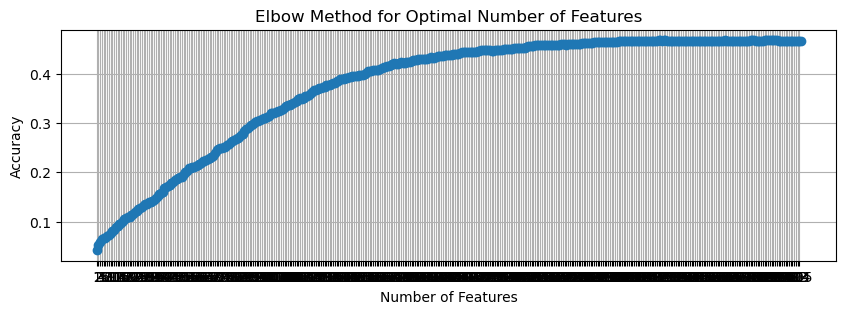

In [125]:
feature_importances = feature_imp_df_drug_id.Feature
accuracies = []

for i in range(1, len(feature_importances)+1):
    selected_features = feature_importances[:i].index
    X_train_selected = X_train_drug_id.iloc[:, selected_features]
    X_test_selected = X_test_drug_id.iloc[:, selected_features]

    catboost_drug_id_2 = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
    catboost_drug_id_2.fit(X_train_selected, y_train_drug_id)
    y_pred = catboost_drug_id_2.predict(X_test_selected)
    accuracies.append(r2_score(y_test_drug_id, y_pred))
    y_pred_train = catboost_drug_id_2.predict(X_train_selected)
    print(f"Train RMSE: {r2_score(y_train_drug_id, y_pred_train)}")
    print(f"Test RMSE: {accuracies[-1]}")
    del catboost_drug_id_2

plt.figure(figsize=(10, 3))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xticks(np.arange(1, len(feature_importances), 1))
plt.title('Elbow Method for Optimal Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

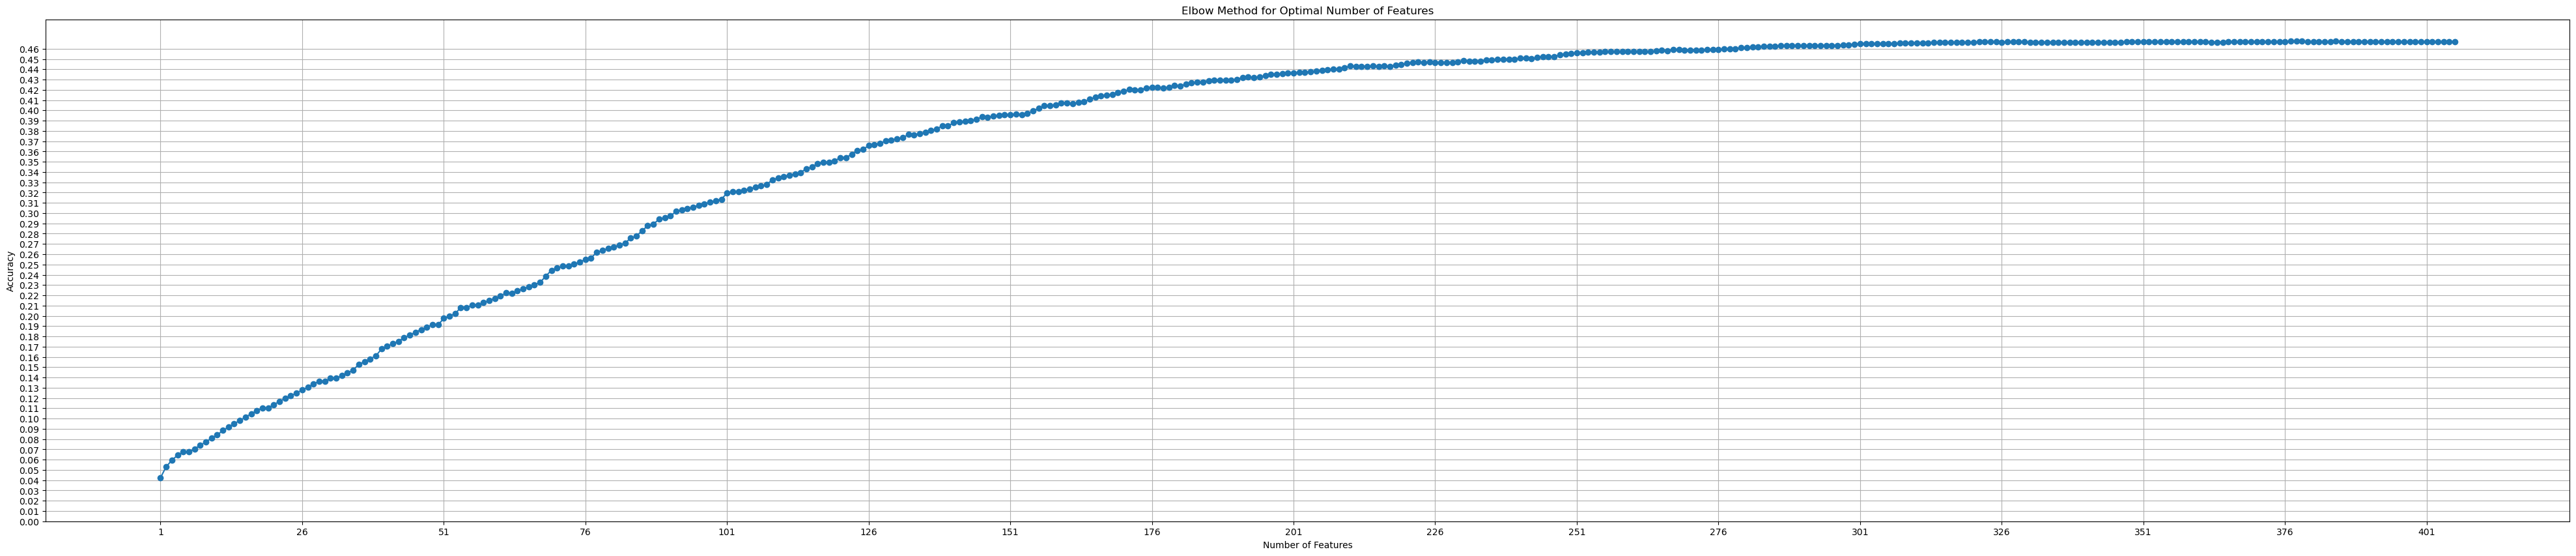

In [131]:
plt.figure(figsize=(50, 10))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xticks(np.arange(1, len(feature_importances), 25))
plt.yticks(np.arange(0, np.max(accuracies), 0.01))
plt.title('Elbow Method for Optimal Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Taking first 250 feature is sufficient to feed model.</h2>
</div>

In [33]:
X_drug_df = pd.concat([X, drug_df.iloc[:,feature_imp_df_drug_id["Feature"][:250].index]], axis=1)

In [34]:
X_drug_df

,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,cp_time_24,...,drug_id_5735a3e0f,drug_id_3ee3c4f73,drug_id_cd7f6bf39,drug_id_20c439875,drug_id_81ef43f78,drug_id_5e6359c7c,drug_id_26a49c7f8,drug_id_3d6cf8034,drug_id_ea54815a3,drug_id_f2b81ca2e
0,-0.132293,-0.133383,0.357710,0.253488,0.941469,-1.136010,0.016309,0.110647,-0.259852,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.531818,-0.635519,-0.388408,-0.230593,0.680430,0.826543,1.255156,-0.739346,-0.648797,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.685792,-1.155077,-0.920859,0.245479,0.002656,0.602549,0.015226,0.390653,-1.132681,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.373990,-0.542576,-0.702529,-1.319536,0.141374,-2.201130,-0.817164,-0.160564,-0.004769,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.449325,0.244811,-0.252866,-0.622214,0.438755,0.737301,-0.526465,-0.653689,-0.950623,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22823,0.516935,-1.396919,0.152807,0.290296,-0.096480,2.666534,-0.329622,0.618883,-0.301461,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22824,-0.105286,0.778199,0.175567,0.348669,0.849665,1.350190,-0.232379,-0.130893,-1.332653,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22825,0.438032,1.495995,0.254508,-0.528029,-0.031875,0.134160,0.320971,0.346726,-0.028330,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22826,-0.221913,0.213595,0.656053,2.527591,1.123188,-0.434306,0.445438,-0.867326,-0.021720,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())

I see 1 GPU devices


In [1]:
from numba import cuda 
device = cuda.get_current_device()
device. reset()
"""
import tensorflow as tf
tf.keras.backend.clear_session()"""

'\nimport tensorflow as tf\ntf.keras.backend.clear_session()'

In [34]:
# joblib.dump(best_model, "catboost_regressor.pkl")

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Without Drug Id Feature</h2>
</div>

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Linear Regression and SVR</h2>
</div>

In [35]:
def grid_search_fun(X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        break   
        
    param_grid_list = [ 
        {
            'algorithm' : ['svd', 'eig', 'qr', 'svd-qr', 'svd-jacobi']
        },
        {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C' : [1,5,10],
            'degree' : [3,8],
            'coef0' : [0.01,10,0.5],
            'gamma' : ('auto','scale')
        }]
    model = {"LinearRegression" : LinearRegression(),
            "SVR": SVR()}
    for ind, (model_name, regressor) in enumerate(model.items()):
        best_hyperparameters = {}
        best_values = {}
        grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_list[ind], scoring='r2', cv=5)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_hyperparameters = list(best_params.keys())
        best_values = list (best_params.values())
    
        if(model_name == "CatBoostRegressor"):
            best_model = CatBoostRegressor(**best_params, eval_metric="RMSE", task_type="GPU", devices='0', gpu_ram_part=0.9)
        elif(model_name == "SVR"):
            best_model = SVR(**best_params)
        elif(model_name == "RandomForestRegressor"):
            best_model = RandomForestRegressor(**best_params, random_state=42)
        elif(model_name == "XGBRegressor"):
            best_model = XGBRegressor(**best_params, random_state=42, n_jobs = -1)
        elif(model_name == "LinearRegression"):
            best_model = LinearRegression(**best_params)
            
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        print('\n\nBest hyperparameters:', best_hyperparameters)
        print('Best values:', best_values)
        print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
        print(f"Test RMSE: {r2_score(y_test, y_pred)}")
        joblib.dump(best_model, "tuned_"+model_name+ ".pkl")
        del best_model
    del model

In [36]:
%%time
grid_search_fun(X, y)



Best hyperparameters: ['algorithm']
Best values: ['svd']
Train RMSE: 0.01731844341223643
Test RMSE: 0.021265741937556926
[W] [13:14:19.243143] SVR with the linear kernel can be much faster using the specialized solver provided by LinearSVR. Consider switching to LinearSVR if tranining takes too long.


Best hyperparameters: ['C', 'coef0', 'degree', 'gamma', 'kernel']
Best values: [1, 0.01, 3, 'auto', 'linear']
Train RMSE: -0.17434616964267602
Test RMSE: -0.17272393452182522
CPU times: user 3min 58s, sys: 48 s, total: 4min 46s
Wall time: 5min 3s


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Random Forest Regressor</h2>
</div>

In [40]:
def grid_search_fun2(X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        break   
        
    param_grid_list = [ 
        {
            'n_estimators': [300, 400, 500],
            'max_depth': [16, 32],
            'min_samples_split': [6, 8, 16],
            
        }]
    
    model = {
        "RandomForestRegressor" : RandomForestRegressor(random_state=42)}
        
    for ind, (model_name, regressor) in enumerate(model.items()):
        best_hyperparameters = {}
        best_values = {}
        grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_list[ind], scoring='r2', cv=5)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_hyperparameters = list(best_params.keys())
        best_values = list (best_params.values())
    
        if(model_name == "CatBoostRegressor"):
            best_model = CatBoostRegressor(**best_params, eval_metric="RMSE", task_type="GPU", devices='0', gpu_ram_part=0.9)
        elif(model_name == "SVR"):
            best_model = SVR(**best_params)
        elif(model_name == "RandomForestRegressor"):
            best_model = RandomForestRegressor(**best_params, random_state=42)
        elif(model_name == "XGBRegressor"):
            best_model = XGBRegressor(**best_params, random_state=42, n_jobs = -1)
        elif(model_name == "LinearRegression"):
            best_model = LinearRegression(**best_params)
            
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        print('\n\nBest hyperparameters:', best_hyperparameters)
        print('Best values:', best_values)
        print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
        print(f"Test RMSE: {r2_score(y_test, y_pred)}")
        joblib.dump(best_model, "tuned_"+model_name+ ".pkl")
        del best_model
    del model

In [41]:
%%time
grid_search_fun2(X, y)



Best hyperparameters: ['max_depth', 'min_samples_split', 'n_estimators']
Best values: [16, 6, 300]
Train RMSE: 0.4432562752877751
Test RMSE: 0.014052597088262786
CPU times: user 6min 20s, sys: 4min 51s, total: 11min 11s
Wall time: 4min 6s


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Catboost Regressor</h2>
</div>

In [31]:
def grid_search_fun3(X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        break   
        
    param_grid_list = [ 
        {
            'iterations': [1000, 1500, 2000],
            'l2_leaf_reg': [1, 3, 5],
            'learning_rate': [0.01, 0.05],  
            'early_stopping_rounds': [50, 100]
        }]
    
    
    model = {
        "CatBoostRegressor": CatBoostRegressor(verbose=0, eval_metric="RMSE", task_type="GPU", devices='0', gpu_ram_part=0.9)}
        
    for ind, (model_name, regressor) in enumerate(model.items()):
        best_hyperparameters = {}
        best_values = {}
        grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_list[ind], scoring='r2', cv=5)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_hyperparameters = list(best_params.keys())
        best_values = list (best_params.values())
    
        if(model_name == "CatBoostRegressor"):
            best_model = CatBoostRegressor(**best_params, eval_metric="RMSE", task_type="GPU", devices='0', gpu_ram_part=0.9)
        elif(model_name == "SVR"):
            best_model = SVR(**best_params)
        elif(model_name == "RandomForestRegressor"):
            best_model = RandomForestRegressor(**best_params, random_state=42)
        elif(model_name == "XGBRegressor"):
            best_model = XGBRegressor(**best_params, random_state=42, n_jobs = -1)
        elif(model_name == "LinearRegression"):
            best_model = LinearRegression(**best_params)
            
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        print('\n\nBest hyperparameters:', best_hyperparameters)
        print('Best values:', best_values)
        print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
        print(f"Test RMSE: {r2_score(y_test, y_pred)}")
        joblib.dump(best_model, "tuned_"+model_name+ ".pkl")
        del best_model
    del model

In [32]:
%%time
grid_search_fun3(X, y) # catboost ve random forest aynı sonucu verdi mi?

0:	learn: 67.6339526	total: 13.7ms	remaining: 13.7s
1:	learn: 67.6168381	total: 25.4ms	remaining: 12.7s
2:	learn: 67.6009959	total: 37ms	remaining: 12.3s
3:	learn: 67.5855972	total: 48ms	remaining: 11.9s
4:	learn: 67.5702209	total: 58.9ms	remaining: 11.7s
5:	learn: 67.5553761	total: 69.9ms	remaining: 11.6s
6:	learn: 67.5402653	total: 80.9ms	remaining: 11.5s
7:	learn: 67.5248722	total: 91.8ms	remaining: 11.4s
8:	learn: 67.5106404	total: 103ms	remaining: 11.3s
9:	learn: 67.4975705	total: 114ms	remaining: 11.3s
10:	learn: 67.4850661	total: 124ms	remaining: 11.2s
11:	learn: 67.4725919	total: 137ms	remaining: 11.2s
12:	learn: 67.4638231	total: 149ms	remaining: 11.3s
13:	learn: 67.4514131	total: 162ms	remaining: 11.4s
14:	learn: 67.4389976	total: 179ms	remaining: 11.7s
15:	learn: 67.4263979	total: 190ms	remaining: 11.7s
16:	learn: 67.4132760	total: 201ms	remaining: 11.6s
17:	learn: 67.4038106	total: 211ms	remaining: 11.5s
18:	learn: 67.3915196	total: 222ms	remaining: 11.5s
19:	learn: 67.3801

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">XGB Regressor</h2>
</div>

In [33]:
def grid_search_fun3(X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        break   
        
    param_grid_list = [
        {
            'n_estimators': [3000, 4000],
            'max_depth': [16, 32],
            'learning_rate': [0.01, 0.05, 0.1]
        }]
    
    
    model = {
        "XGBRegressor" : XGBRegressor(random_state=42)}
        
    for ind, (model_name, regressor) in enumerate(model.items()):
        best_hyperparameters = {}
        best_values = {}
        grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid_list[ind], scoring='r2', cv=5)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_hyperparameters = list(best_params.keys())
        best_values = list (best_params.values())
    
        if(model_name == "CatBoostRegressor"):
            best_model = CatBoostRegressor(**best_params, eval_metric="RMSE", task_type="GPU", devices='0', gpu_ram_part=0.9)
        elif(model_name == "SVR"):
            best_model = SVR(**best_params)
        elif(model_name == "RandomForestRegressor"):
            best_model = RandomForestRegressor(**best_params, random_state=42)
        elif(model_name == "XGBRegressor"):
            best_model = XGBRegressor(**best_params, random_state=42, n_jobs = -1)
        elif(model_name == "LinearRegression"):
            best_model = LinearRegression(**best_params)
            
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        print('\n\nBest hyperparameters:', best_hyperparameters)
        print('Best values:', best_values)
        print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
        print(f"Test RMSE: {r2_score(y_test, y_pred)}")
        joblib.dump(best_model, "tuned_"+model_name+ ".pkl")
        del best_model
    del model

In [34]:
%%time
grid_search_fun3(X, y)



Best hyperparameters: ['learning_rate', 'max_depth', 'n_estimators']
Best values: [0.01, 16, 3000]
Train RMSE: 0.9999996423721313
Test RMSE: -0.07088828086853027
CPU times: user 22h 32min 43s, sys: 42.3 s, total: 22h 33min 25s
Wall time: 1h 8min 21s


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">Lasso, Ridge Regressor</h2>
</div>

In [43]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    break   

In [46]:
def cross_validation_regression(X_train, y_train, model, early_stopping_flag=False, n_folds=5):
    mse_list = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X_train):
       
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        if early_stopping_flag: # if early stopping model is true then use lgb model
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
                      callbacks=[lgbm.early_stopping(stopping_rounds=250, verbose=0)])
        else:
            model.fit(X_train_fold, y_train_fold)
            
        y_pred = model.predict(X_val_fold)
        mse = MSE(y_val_fold, y_pred, squared=False)
        mse_list.append(mse)
    return model, np.sqrt(np.mean(mse_list)) # Return the trained model and the average RMSE score

In [47]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-5, 100, log=True)
    model_type = trial.suggest_categorical("model_type", ["ridge", "lasso"])

    if model_type == "ridge":
        model = Ridge(alpha=alpha)
    elif (model_type == "lasso"):
        model = Lasso(alpha=alpha)
        
    model, mean_rmse = cross_validation_regression(X_train, y_train, model, False)
    return mean_rmse

In [48]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# get best hyperparameters and score
best_params_lr = study.best_params
best_score_lr = study.best_value

# print best hyperparameters and score
print(f"Best hyperparameters: {best_params_lr}")
print(f"Best MSE: {best_score_lr:.4f}")

[I 2024-12-09 17:14:06,629] A new study created in memory with name: no-name-4be1ed92-0ed4-4c34-ba32-c9bdc5211d02
[I 2024-12-09 17:14:08,805] Trial 0 finished with value: 8.218024141581067 and parameters: {'alpha': 4.062943806544133, 'model_type': 'lasso'}. Best is trial 0 with value: 8.218024141581067.
[I 2024-12-09 17:14:08,886] Trial 1 finished with value: 8.194438657373416 and parameters: {'alpha': 0.8923479229758605, 'model_type': 'lasso'}. Best is trial 1 with value: 8.194438657373416.
[I 2024-12-09 17:14:08,964] Trial 2 finished with value: 8.224892717670123 and parameters: {'alpha': 17.31646922332353, 'model_type': 'lasso'}. Best is trial 1 with value: 8.194438657373416.
[I 2024-12-09 17:14:09,047] Trial 3 finished with value: 8.192588690989488 and parameters: {'alpha': 0.12376927424397273, 'model_type': 'lasso'}. Best is trial 3 with value: 8.192588690989488.
[I 2024-12-09 17:14:09,153] Trial 4 finished with value: 8.192676559858006 and parameters: {'alpha': 0.0023988783415745

Best hyperparameters: {'alpha': 0.12376927424397273, 'model_type': 'lasso'}
Best MSE: 8.1926


In [49]:
if best_params_lr['model_type'] == "lasso":
    lr_model = Lasso(alpha=best_params_lr['alpha'])
elif best_params_lr['model_type'] == "ridge":
    lr_model = Ridge(alpha=best_params_lr['alpha'])
else:
    # handle error
    print("Error: invalid model type")

In [50]:
lr_model.fit(X_train, y_train)

# make predictions on the test data using the Linear Regression model
y_pred_lr = lr_model.predict(X_test)
y_pred_train_lr = lr_model.predict(X_train)
# calculate and print the RMSE using the Linear Regression model
print("Best rmse:", np.sqrt(MSE(y_test, y_pred_lr)))
print(f"Train RMSE: {r2_score(y_train, y_pred_train_lr)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_lr)}")

Best rmse: 66.85727561648324
Train RMSE: 0.017250075560930056
Test RMSE: 0.021037442046440202


<div style="color: white; display: block; border-radius: 5px; background-color: red; width: 100%; height: 60%; font-size: 100%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">As a result, Without SMOTE Catboost Algorithm has produced best result.</h2>
</div>

<div style="color: white; display: block; border-radius: 5px; background-color:blue; width: 100%; height: 60%; font-size: 100%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">With Drug Id Feature And Smote</h2>
</div>

In [35]:
X_drug_df.head(3)

,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,cp_time_24,...,drug_id_5735a3e0f,drug_id_3ee3c4f73,drug_id_cd7f6bf39,drug_id_20c439875,drug_id_81ef43f78,drug_id_5e6359c7c,drug_id_26a49c7f8,drug_id_3d6cf8034,drug_id_ea54815a3,drug_id_f2b81ca2e
0,-0.132293,-0.133383,0.357710,0.253488,0.941469,-1.136010,0.016309,0.110647,-0.259852,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.531818,-0.635519,-0.388408,-0.230593,0.680430,0.826543,1.255156,-0.739346,-0.648797,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.685792,-1.155077,-0.920859,0.245479,0.002656,0.602549,0.015226,0.390653,-1.132681,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_drug_df, y):
    X_train, X_test = X_drug_df.loc[train_index], X_drug_df.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    break   

In [166]:
X_train

,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,cp_time_24,...,drug_id_5735a3e0f,drug_id_3ee3c4f73,drug_id_cd7f6bf39,drug_id_20c439875,drug_id_81ef43f78,drug_id_5e6359c7c,drug_id_26a49c7f8,drug_id_3d6cf8034,drug_id_ea54815a3,drug_id_f2b81ca2e
0,-0.132293,-0.133383,0.357710,0.253488,0.941469,-1.136010,0.016309,0.110647,-0.259852,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.685792,-1.155077,-0.920859,0.245479,0.002656,0.602549,0.015226,0.390653,-1.132681,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.373990,-0.542576,-0.702529,-1.319536,0.141374,-2.201130,-0.817164,-0.160564,-0.004769,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.271616,-0.970553,0.963137,1.034593,-0.137856,-0.359936,-0.875354,-0.726760,-0.303733,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.562701,0.733261,0.109935,2.215397,0.472953,-0.674294,0.317939,-1.850212,-1.022385,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22822,0.396217,0.385933,0.176111,0.154964,0.070710,-0.693155,-1.019792,-0.645257,-0.466321,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22824,-0.105286,0.778199,0.175567,0.348669,0.849665,1.350190,-0.232379,-0.130893,-1.332653,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22825,0.438032,1.495995,0.254508,-0.528029,-0.031875,0.134160,0.320971,0.346726,-0.028330,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22826,-0.221913,0.213595,0.656053,2.527591,1.123188,-0.434306,0.445438,-0.867326,-0.021720,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
catboost_drug_df = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_drug_df.fit(X_train, y_train)
y_pred = catboost_drug_df.predict(X_test)
y_pred_train = catboost_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
print(f"Test RMSE: {r2_score(y_test, y_pred)}")

Train RMSE: 0.49235895287889186
Test RMSE: 0.45586906081064793


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 100%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Remember without drug id feature score (below).</h4>
</div>

In [174]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_drug_df.iloc[:, :12], y):
    X_train, X_test = X_drug_df.iloc[:, :12].loc[train_index], X_drug_df.iloc[:, :12].loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    break   

In [175]:
catboost_drug_df = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_drug_df.fit(X_train, y_train)
y_pred = catboost_drug_df.predict(X_test)
y_pred_train = catboost_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
print(f"Test RMSE: {r2_score(y_test, y_pred)}")

Train RMSE: 0.14023921532758143
Test RMSE: 0.016663750881914408


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 100%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">SMOTE Dataset and Apply ML Algorithms.</h4>
</div>

In [176]:
!pip install imblearn -q

In [180]:
from imblearn.over_sampling import SMOTENC

In [ ]:
sm = SMOTENC(random_state=42)
X_res, y_res = sm.fit_resample(X_drug_df, y)
print(f'Resampled dataset samples per class {Counter(y_res)}')

In [181]:
!pip install smogn

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 60%; font-size: 100%; font-family: Verdana; letter-spacing: 0.5px;">
    <h2 style="padding: 10px; color: white;">SMOGN</h2>
</div>


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">To combine with the Synthetic Minority Oversampling Technique (SMOTE) over-sampling algorithm, performing feature selection first and over-sampling second outperforms the other procedure.</h4>
</div>

In [39]:
!pip install smogn -q

In [41]:
import smogn
smogn.smoter

<function smogn.smoter.smoter(data, y, k=5, pert=0.02, samp_method='balance', under_samp=True, drop_na_col=True, drop_na_row=True, replace=False, rel_thres=0.5, rel_method='auto', rel_xtrm_type='both', rel_coef=1.5, rel_ctrl_pts_rg=None)>

In [184]:
import smogn

new_df = pd.concat([X_drug_df, y],axis=1)
df_smogn = smogn.smoter(data=new_df, y="label")

r_index: 100%|#####################################################################| 2639/2639 [00:15<00:00, 171.46it/s]


In [47]:
df_smogn.head(3)

,Unnamed: 0,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,...,drug_id_3ee3c4f73,drug_id_cd7f6bf39,drug_id_20c439875,drug_id_81ef43f78,drug_id_5e6359c7c,drug_id_26a49c7f8,drug_id_3d6cf8034,drug_id_ea54815a3,drug_id_f2b81ca2e,label
0,0,0.00000,0.913517,0.79469,0.000000,0.832209,0.226718,0.500502,0.0,0.110269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0
1,1,0.53642,0.496017,0.00000,0.000000,1.547828,0.704440,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0
2,2,0.83542,0.796522,0.00000,0.180371,1.843817,0.939955,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0


In [54]:
if 'Unnamed: 0' in df_smogn.columns:
    df_smogn.drop(columns=['Unnamed: 0'], inplace=True)

In [55]:
df_smogn.head(3)

,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,cp_time_24,...,drug_id_3ee3c4f73,drug_id_cd7f6bf39,drug_id_20c439875,drug_id_81ef43f78,drug_id_5e6359c7c,drug_id_26a49c7f8,drug_id_3d6cf8034,drug_id_ea54815a3,drug_id_f2b81ca2e,label
0,0.00000,0.913517,0.79469,0.000000,0.832209,0.226718,0.500502,0.0,0.110269,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0
1,0.53642,0.496017,0.00000,0.000000,1.547828,0.704440,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0
2,0.83542,0.796522,0.00000,0.180371,1.843817,0.939955,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0


In [188]:
# df_smogn.to_csv("df_smogn.csv")
# new_df.to_csv("new_df.csv")

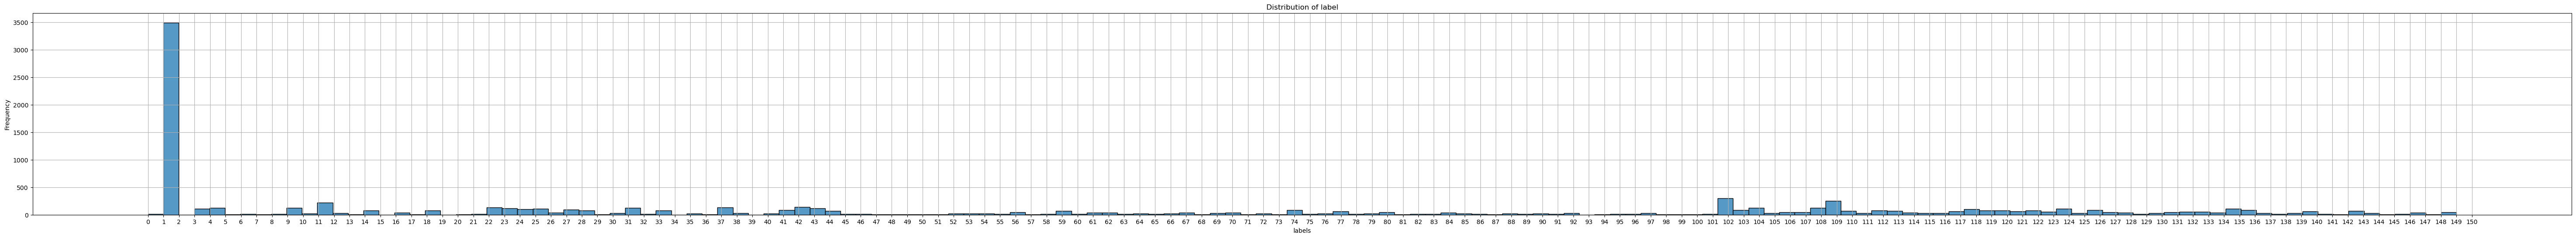

In [45]:
plt.figure(figsize=(75, 6))
sns.histplot(data=df_smogn[df_smogn.label < 150], x='label', bins=150)
plt.title('Distribution of label')
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(range(0, 151, 1))
plt.show()

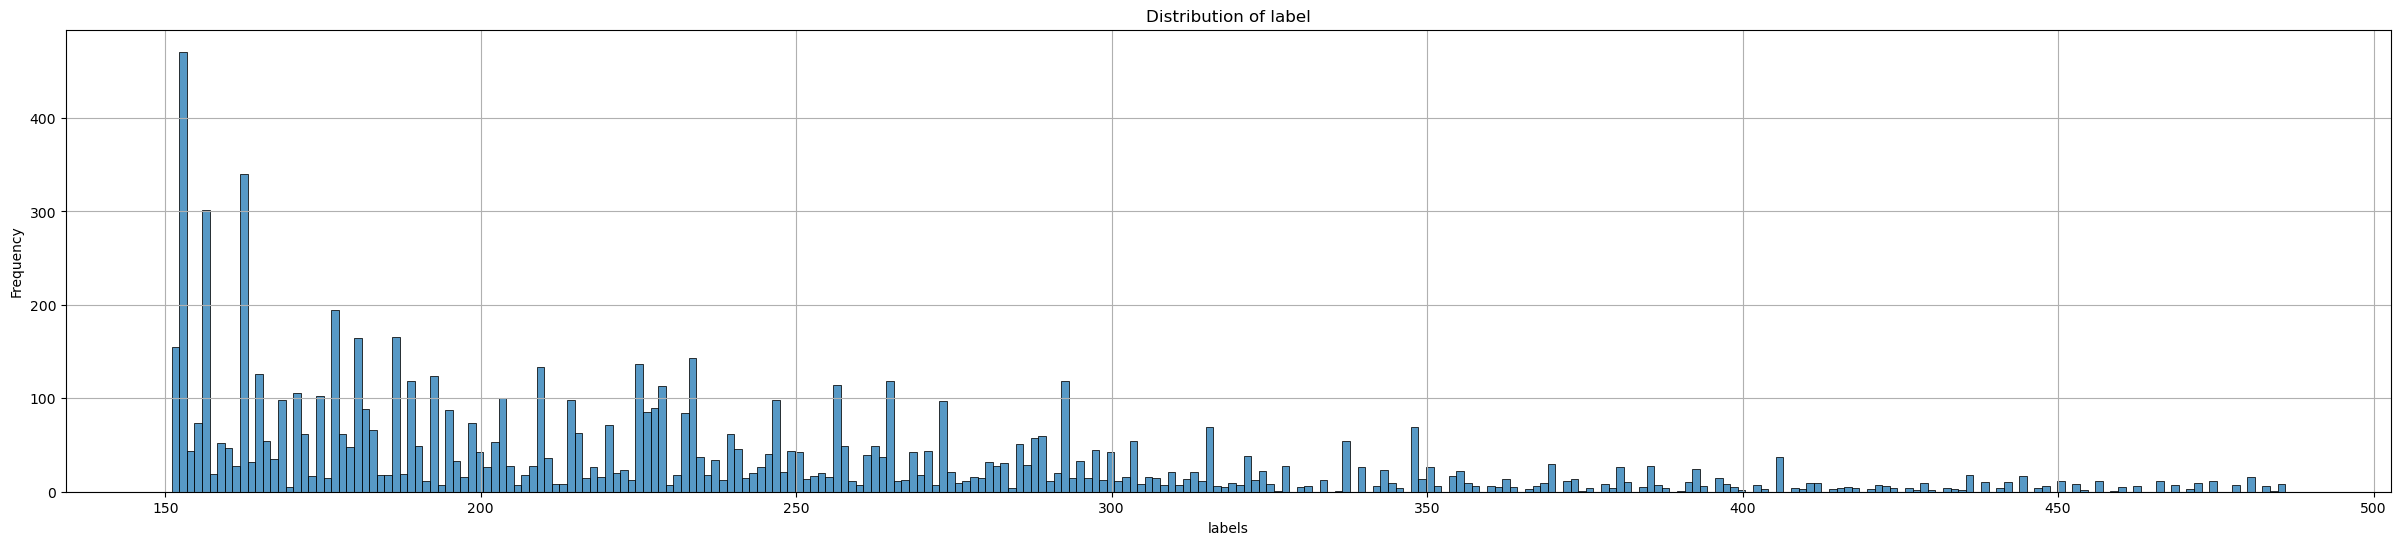

In [46]:
plt.figure(figsize=(30, 6))
sns.histplot(data=df_smogn[df_smogn.label > 150], x='label', bins=(df_smogn.label.nunique()-150))
plt.title('Distribution of label')
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.grid(True)
# plt.xticks(range(0, (train_df.label.nunique()-150), 1))
plt.show()

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">With drug feature Result</h4>
</div>

In [58]:
y = df_smogn["label"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(df_smogn, y):
    X_train, X_test = df_smogn.loc[train_index], df_smogn.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    break   

In [60]:
catboost_smogn_drug_df = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_smogn_drug_df.fit(X_train, y_train)
y_pred = catboost_smogn_drug_df.predict(X_test)
y_pred_train = catboost_smogn_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
print(f"Test RMSE: {r2_score(y_test, y_pred)}")

Train RMSE: 0.9999161731429382
Test RMSE: 0.9998960805218851


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Without drug feature Result. As test set has no drug id, below models will be used to predict test set label/target value. </h4>
</div>

In [106]:
y = df_smogn["label"]

drug_feature_names = list([x for x in df_smogn.columns if 'drug_id_' in x])
drug_feature_names.extend(["label"])
X = df_smogn.drop(columns = drug_feature_names)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    break   

In [109]:
X_train.head(3)

,PC_c4,PC_g35,PC_g26,PC_g29,PC_g33,PC_g59,PC_g16,PC_g12,PC_g31,cp_time_24,cp_time_48,cp_time_72
3,0.000000,0.000000,0.334594,0.0,0.653301,0.000000,0.00000,0.0,0.000000,1.0,0.0,0.0
4,0.034333,0.437548,0.000000,0.0,0.620390,0.826716,0.00000,0.0,0.503787,0.0,1.0,0.0
5,0.671137,0.000000,0.101913,0.0,0.000000,0.862857,0.25278,0.0,0.811636,0.0,0.0,1.0


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Catboost</h4>
</div>

In [110]:
catboost_2_smogn_drug_df = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_2_smogn_drug_df.fit(X_train, y_train)
y_pred_catboost = catboost_2_smogn_drug_df.predict(X_test)
y_pred_train_catboost = catboost_2_smogn_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_catboost)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_catboost)}")

Train RMSE: 0.5409477568295415
Test RMSE: 0.448520374551156


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Random Forest</h4>
</div>

In [111]:
rf_smogn_drug_df = RandomForestRegressor(random_state=42)
rf_smogn_drug_df.fit(X_train, y_train)
y_pred_rf = rf_smogn_drug_df.predict(X_test)
y_pred_train_rf = rf_smogn_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_rf)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_rf)}")

Train RMSE: 0.7511570796146444
Test RMSE: 0.4477709687556779


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">LightGBM</h4>
</div>

In [115]:
!pip install lightgbm -q

In [116]:
import lightgbm as lgb
lgb_smogn_drug_df = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgb_smogn_drug_df.fit(X_train, y_train)
y_pred_lgb = lgb_smogn_drug_df.predict(X_test)
y_pred_train_lgb = lgb_smogn_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_lgb)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_lgb)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 14752, number of used features: 12
[LightGBM] [Info] Start training from score 132.789046
Train RMSE: 0.5814470643536097
Test RMSE: 0.44865020682014844


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Lineer Regression</h4>
</div>

In [117]:
linear_smogn_drug_df = LinearRegression()
linear_smogn_drug_df.fit(X_train, y_train)
y_pred_lgb = linear_smogn_drug_df.predict(X_test)
y_pred_train_lgb = linear_smogn_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_lgb)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_lgb)}")

Train RMSE: 0.05640006573545142
Test RMSE: 0.06347162195969414


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Knn Regressor</h4>
</div>

In [133]:
from cuml.neighbors import KNeighborsRegressor
knn_smogn_drug_df = KNeighborsRegressor()
knn_smogn_drug_df.fit(X_train, y_train)
y_pred_lgb = knn_smogn_drug_df.predict(X_test)
y_pred_train_lgb = knn_smogn_drug_df.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_lgb)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_lgb)}")

Train RMSE: 0.5429588299376377
Test RMSE: 0.2870938854040024


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Grid-search and cv for Regressor</h4>
</div>

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">lbgmRegressor</h4>
</div>

In [139]:
lgb_smogn_drug_df.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [183]:
def grid_search_fun(param_grid:dict, estimator, estimator_type:object, X, y, scores, cv=5):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        break
    
    best_hyperparameters = {}
    best_values = {}
    
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                               scoring='r2', cv=cv)
     
    # Fit the model to the training data to search for the best hyperparameters
    grid_search.fit(X_train, y_train)
     
    # Get the best hyperparameters and their values
    best_params = grid_search.best_params_
    best_hyperparameters = list(best_params.keys())
    best_values = list(best_params.values())
    best_model = estimator_type(**best_params)
    best_model.fit(X_train, y_train)
    
    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    # Calculate accuracy
    
    print(f"Train RMSE: {r2_score(y_train, y_pred_train)}")
    print(f"Test RMSE: {r2_score(y_test, y_pred)}")
    scores.append([r2_score(y_train, y_pred_train), r2_score(y_test, y_pred)])
    print('\n\nBest hyperparameters:', best_hyperparameters)
    print('Best values:', best_values)
    return best_model, scores

In [184]:
%%time
scores=[]
param_grid = {
    'num_leaves': [31, 51],
    'learning_rate': [0.05, 0.1,  0.01],
    'n_estimators': [100, 300]
}
drug_feature_names = list([x for x in df_smogn.columns if 'drug_id_' in x])
drug_feature_names.extend(["label"])
X = df_smogn.drop(columns = drug_feature_names)
y = df_smogn["label"]
lgb_smogn_drug_df = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgb_smogn_drug_df_best, scores = grid_search_fun(param_grid, lgb_smogn_drug_df, lgb.LGBMRegressor, X, y, scores)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 11801, number of used features: 12
[LightGBM] [Info] Start training from score 116.365308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 11801, number of used features: 12
[LightGBM] [Info] Start training from score 107.902296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Catboost</h4>
</div>

In [160]:
catboost_2_smogn_drug_df.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.9,
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Ordered',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'devices': '0',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'meta_l2_frequency': 0,
 'random_seed': 0,
 'depth': 6,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'FeatureParallel',
 'bagging_temperature

In [185]:
%%time
param_grid = {
    'learning_rate': [0.05, 0.1,  0.01],
    'max_leaves': [64, 128]
}
catboost_2_smogn_drug_df = CatBoostRegressor(verbose=0, eval_metric="RMSE",                                    
                                  task_type="GPU", devices='0', gpu_ram_part=0.9)
catboost_2_smogn_drug_df_best, scores = grid_search_fun(param_grid, catboost_2_smogn_drug_df, catboost.core.CatBoostRegressor, X, y, scores)

0:	learn: 109.6047626	total: 8.32ms	remaining: 8.31s
1:	learn: 109.1827271	total: 13.3ms	remaining: 6.62s
2:	learn: 108.7622760	total: 16.3ms	remaining: 5.41s
3:	learn: 108.3463410	total: 18.4ms	remaining: 4.58s
4:	learn: 107.9351654	total: 21.4ms	remaining: 4.26s
5:	learn: 107.5258744	total: 23.6ms	remaining: 3.92s
6:	learn: 107.1428799	total: 24.9ms	remaining: 3.53s
7:	learn: 106.7477112	total: 26.6ms	remaining: 3.3s
8:	learn: 106.3620423	total: 28.6ms	remaining: 3.15s
9:	learn: 105.9777360	total: 30.3ms	remaining: 3s
10:	learn: 105.6005667	total: 32.7ms	remaining: 2.94s
11:	learn: 105.2332503	total: 34ms	remaining: 2.8s
12:	learn: 104.8686402	total: 35.3ms	remaining: 2.68s
13:	learn: 104.5099063	total: 37.8ms	remaining: 2.66s
14:	learn: 104.1589919	total: 39.1ms	remaining: 2.57s
15:	learn: 103.8241535	total: 40.4ms	remaining: 2.48s
16:	learn: 103.4869928	total: 42.3ms	remaining: 2.44s
17:	learn: 103.1399681	total: 43.7ms	remaining: 2.38s
18:	learn: 102.8194882	total: 45ms	remaining:

<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Random Forest Regressor</h4>
</div>

In [166]:
rf_smogn_drug_df.get_params()

{'handle': <pylibraft.common.handle.Handle at 0x7f3e6ba7ebb0>,
 'verbose': 4,
 'output_type': 'input',
 'n_estimators': 100,
 'max_depth': 16,
 'max_features': 'sqrt',
 'n_bins': 128,
 'split_criterion': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_impurity_decrease': 0.0,
 'bootstrap': True,
 'max_samples': 1.0,
 'max_leaves': -1,
 'accuracy_metric': 'r2',
 'max_batch_size': 4096,
 'n_streams': 4,
 'dtype': dtype('float64'),
 'min_weight_fraction_leaf': None,
 'n_jobs': None,
 'max_leaf_nodes': None,
 'min_impurity_split': None,
 'oob_score': None,
 'random_state': 42,
 'warm_start': None,
 'class_weight': None,
 'criterion': None}

In [186]:
%%time
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [16, 32, 64],
    'split_criterion': [2, 4, 6]
}
rf_smogn_drug_df = RandomForestRegressor(random_state=42)
rf_smogn_drug_df_best, scores = grid_search_fun(param_grid, rf_smogn_drug_df, cuml.ensemble.randomforestregressor.RandomForestRegressor, X, y, scores, cv=10)

Train RMSE: 0.9069934677721022
Test RMSE: 0.4492366275177203


Best hyperparameters: ['max_depth', 'n_estimators', 'split_criterion']
Best values: [32, 300, 6]
CPU times: user 13min 28s, sys: 9min 51s, total: 23min 20s
Wall time: 7min 48s


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Voting Regression</h4>
</div>

In [173]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('catboost', catboost_2_smogn_drug_df_best), ('rf', rf_smogn_drug_df_best), ('lightgbm', lgb_smogn_drug_df_best)], n_jobs=-1)

In [174]:
%%time
voting_regressor.fit(X_train, y_train)
y_pred_voting = voting_regressor.predict(X_test)
y_pred_train_voting = voting_regressor.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_voting)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_voting)}")

0:	learn: 109.6047626	total: 52.6ms	remaining: 52.6s
1:	learn: 109.1827271	total: 54.5ms	remaining: 27.2s
2:	learn: 108.7622760	total: 55.7ms	remaining: 18.5s
3:	learn: 108.3463410	total: 57.2ms	remaining: 14.2s
4:	learn: 107.9351654	total: 58.4ms	remaining: 11.6s
5:	learn: 107.5258744	total: 59.7ms	remaining: 9.89s
6:	learn: 107.1428799	total: 61.4ms	remaining: 8.71s
7:	learn: 106.7477112	total: 62.7ms	remaining: 7.78s
8:	learn: 106.3620423	total: 64.1ms	remaining: 7.05s
9:	learn: 105.9777360	total: 65.4ms	remaining: 6.48s
10:	learn: 105.6005667	total: 66.6ms	remaining: 5.99s
11:	learn: 105.2332503	total: 67.9ms	remaining: 5.59s
12:	learn: 104.8686402	total: 70.2ms	remaining: 5.33s
13:	learn: 104.5099063	total: 71.5ms	remaining: 5.04s
14:	learn: 104.1589919	total: 72.8ms	remaining: 4.78s
15:	learn: 103.8241535	total: 74.1ms	remaining: 4.56s
16:	learn: 103.4869928	total: 75.4ms	remaining: 4.36s
17:	learn: 103.1399681	total: 77.3ms	remaining: 4.22s
18:	learn: 102.8194882	total: 78.8ms	r

/home/umonoz/yes/envs/rapids-24.10/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train RMSE: 0.6734000387837681
Test RMSE: 0.456200500914857
CPU times: user 1.62 s, sys: 2.24 s, total: 3.86 s
Wall time: 15.9 s


In [187]:
%%time
voting_regressor = voting_regressor.set_params(rf='drop')

voting_regressor.fit(X_train, y_train)
y_pred_voting = voting_regressor.predict(X_test)
y_pred_train_voting = voting_regressor.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_voting)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_voting)}")
scores.append([r2_score(y_train, y_pred_train_voting), r2_score(y_test, y_pred_voting)])

0:	learn: 109.6047626	total: 53ms	remaining: 52.9s
1:	learn: 109.1827271	total: 54.4ms	remaining: 27.2s
2:	learn: 108.7622760	total: 55.7ms	remaining: 18.5s
3:	learn: 108.3463410	total: 56.9ms	remaining: 14.2s
4:	learn: 107.9351654	total: 58.3ms	remaining: 11.6s
5:	learn: 107.5258744	total: 59.6ms	remaining: 9.87s
6:	learn: 107.1428799	total: 60.9ms	remaining: 8.64s
7:	learn: 106.7477112	total: 62.4ms	remaining: 7.74s
8:	learn: 106.3620423	total: 64.9ms	remaining: 7.15s
9:	learn: 105.9777360	total: 67.5ms	remaining: 6.68s
10:	learn: 105.6005667	total: 69ms	remaining: 6.2s
11:	learn: 105.2332503	total: 71.1ms	remaining: 5.86s
12:	learn: 104.8686402	total: 72.8ms	remaining: 5.53s
13:	learn: 104.5099063	total: 75.4ms	remaining: 5.31s
14:	learn: 104.1589919	total: 77.8ms	remaining: 5.11s
15:	learn: 103.8241535	total: 79.4ms	remaining: 4.88s
16:	learn: 103.4869928	total: 82ms	remaining: 4.74s
17:	learn: 103.1399681	total: 83.6ms	remaining: 4.56s
18:	learn: 102.8194882	total: 86.2ms	remainin

In [191]:
pd.DataFrame(data =scores, index=["LightGBM", "Catboost", "RF", "Voting"], columns=["Train", "Test"])

,Train,Test
LightGBM,0.497751,0.449322
Catboost,0.491952,0.448283
RF,0.906993,0.449237
Voting,0.497004,0.450954


<div style="color: white; display: block; border-radius: 5px; background-color: #fc5603; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h4 style="padding: 10px; color: white;">Stacking Regression</h4>
</div>

In [193]:
from sklearn.ensemble import StackingRegressor
estimators = [
    ('lightgbm', lgb_smogn_drug_df_best)
]
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=catboost_2_smogn_drug_df_best)

In [194]:
%%time
stacking_regressor.fit(X_train, y_train)
y_pred_stack = stacking_regressor.predict(X_test)
y_pred_train_stack = stacking_regressor.predict(X_train)

print(f"Train RMSE: {r2_score(y_train, y_pred_train_stack)}")
print(f"Test RMSE: {r2_score(y_test, y_pred_stack)}")
scores.append([r2_score(y_train, y_pred_train_stack), r2_score(y_test, y_pred_stack)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 14752, number of used features: 12
[LightGBM] [Info] Start training from score 132.789046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 11801, number of used features: 12
[LightGBM] [Info] Start training from score 116.365308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 11801, number of used features: 12
[LightGBM] [Info] Start

In [196]:
pd.DataFrame(data =scores, index=["LightGBM", "Catboost", "RF", "Voting", "Stacking"], columns=["Train", "Test"])

,Train,Test
LightGBM,0.497751,0.449322
Catboost,0.491952,0.448283
RF,0.906993,0.449237
Voting,0.497004,0.450954
Stacking,0.401193,0.362844


<div style="color: white; display: block; border-radius: 5px; background-color: violet; width: 100%; height: 75%; font-size: 75%; font-family: Verdana; letter-spacing: 0.5px;">
    <h1 style="padding: 10px; color: white;">Result: Best Model is Voting ensemble model which is powered by giving good results LightGBM and Catboost</h1>
</div>